In [1]:
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
import numpy as np
from data_utils import get_train_batch, get_val_batch, get_test_batch
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Reshape, BatchNormalization, Flatten, Activation
from keras.models import Sequential, Model, load_model
from keras import optimizers, metrics
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.layers import LSTM, Lambda, TimeDistributed, GRU, RepeatVector, CuDNNGRU

Using TensorFlow backend.


In [2]:
%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 6.0)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

def plot_image(image, shape=[64, 64, 3]):
    fig = plt.figure(figsize=(8, 8))
    plt.imshow(image)
    plt.axis("off")

def plot_images(images, num_images):
    fig = plt.figure(figsize=(24, 8))
    for i in range(0, num_images):
        fig.add_subplot(num_images//5, 5, i+1)
        plt.imshow(images[i])
        plt.axis("off")
    plt.show()

In [3]:
encoder = load_model('./models/Encoder_0616_256.hdf5')
decoder = load_model('./models/Decoder_0616_256.hdf5')
encoder.trainable = False
decoder.trainable = False
encoder.summary()
decoder.summary()

Instructions for updating:
Colocations handled automatically by placer.


/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 64, 64, 3)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 64, 64, 128)       3584      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64, 64, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 32, 32, 64)        73792     
_________________________________________________________________
batch_normalization_3 (Batch (None, 32, 32, 64)        256       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 32, 32, 64)        36928     
__________

In [4]:
dim = 4*4*16

time_steps = 10;
num_outputs = 10;
n_train = 20000
n_val = 500

val_input_batch = np.empty(shape = (n_val*2, time_steps, dim), dtype = np.float32)
val_output_batch = np.empty(shape = (n_val*2, num_outputs, dim), dtype = np.float32)
for i in range(n_val):
    inputs, outputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[i] = temp
for i in range(n_val):
    outputs, inputs = get_val_batch(i, i+1)
    inputs = np.reshape(inputs, (-1, 64, 64, 3))
    inputs = np.flip(inputs, 0)
    temp = encoder.predict_on_batch(inputs)
    temp = temp[None, :, :]
    val_input_batch[n_val+i] = temp
    outputs = np.reshape(outputs, (-1, 64, 64, 3))
    outputs = np.flip(outputs, 0)
    temp = encoder.predict_on_batch(outputs)
    temp = temp[None, :, :]
    val_output_batch[n_val+i] = temp

In [20]:
initializer = keras.initializers.glorot_uniform(seed = None)
regularizer = keras.regularizers.l2(1e-6)

inputs = Input(shape = (10, 256))
X = LSTM(1600, activation = 'relu', recurrent_activation = 'hard_sigmoid', kernel_initializer = 'glorot_uniform',
         recurrent_initializer = 'orthogonal', kernel_regularizer = None, dropout = 0.0, recurrent_dropout = 0.0,
         return_sequences = False, go_backwards = False, use_bias = True, bias_initializer = 'zeros',activity_regularizer = None)(inputs)
X = RepeatVector(10)(X)
X = LSTM(1600, activation = 'relu', recurrent_activation = 'hard_sigmoid', kernel_initializer = 'glorot_uniform',
         recurrent_initializer = 'orthogonal', kernel_regularizer = None, dropout = 0.0, recurrent_dropout = 0.0,
         return_sequences = True, go_backwards = False, use_bias = True, bias_initializer = 'zeros',activity_regularizer = None)(X)
outputs = TimeDistributed(Dense(units = 256, activation = 'tanh', kernel_initializer = initializer,
                                bias_initializer = 'zeros', kernel_regularizer = regularizer,), input_shape = (10, 1600))(X)

model = Model(inputs, outputs)

opt = optimizers.Adam(lr = 1e-3, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

In [21]:
model.summary()
dictionary = {v.name: i for i, v in enumerate(model.layers)}

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 10, 256)           0         
_________________________________________________________________
lstm_11 (LSTM)               (None, 1600)              11884800  
_________________________________________________________________
repeat_vector_6 (RepeatVecto (None, 10, 1600)          0         
_________________________________________________________________
lstm_12 (LSTM)               (None, 10, 1600)          20486400  
_________________________________________________________________
time_distributed_6 (TimeDist (None, 10, 256)           409856    
Total params: 32,781,056
Trainable params: 32,781,056
Non-trainable params: 0
_________________________________________________________________


In [5]:
def image_augmentation(inputs, outputs, opt, time_steps = 10):
    inputs_ = np.zeros_like(inputs, dtype = np.float32)
    outputs_ = np.zeros_like(outputs, dtype = np.float32)
    if opt == 0:
        inputs_ = inputs
        outputs_ = outputs
    elif opt == 1:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][:-6, :-6]
            outputs_[i][3:61, 3:61] = outputs[i][:-6, :-6]
    elif opt == 2:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][6:, :-6]
            outputs_[i][3:61, 3:61] = outputs[i][6:, :-6]
    elif opt == 3:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][6:, 6:]
            outputs_[i][3:61, 3:61] = outputs[i][6:, 6:]
    elif opt == 4:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = inputs[i][:-6, 6:]
            outputs_[i][3:61, 3:61] = outputs[i][:-6, 6:]
    elif opt == 5:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = inputs[i][3:61, 3:61]
            outputs_[i][:-6, :-6] = outputs[i][3:61, 3:61]
    elif opt == 6:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = inputs[i][3:61, 3:61]
            outputs_[i][6:, :-6] = outputs[i][3:61, 3:61]
    elif opt == 7:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = inputs[i][3:61, 3:61]
            outputs_[i][6:, 6:] = outputs[i][3:61, 3:61]
    elif opt == 8:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = inputs[i][3:61, 3:61]
            outputs_[i][:-6, 6:] = outputs[i][3:61, 3:61]
    elif opt == 9:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = inputs[i][:-6, :-6]
            outputs_[i][6:, 6:] = outputs[i][:-6, :-6]
    elif opt == 10:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = inputs[i][6:, :-6]
            outputs_[i][:-6, 6:] = outputs[i][6:, :-6]
    elif opt == 11:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = inputs[i][6:, 6:]
            outputs_[i][:-6, :-6] = outputs[i][6:, 6:]
    elif opt == 12:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = inputs[i][:-6, 6:]
            outputs_[i][6:, :-6] = outputs[i][:-6, 6:]
    elif opt == 13:
        for i in range(time_steps):
            inputs_[i][:, :] = np.fliplr(inputs[i][:, :])
            outputs_[i][:, :] = np.fliplr(outputs[i][:, :])
    elif opt == 14:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.fliplr(inputs[i][:-6, :-6])
            outputs_[i][3:61, 3:61] = np.fliplr(outputs[i][:-6, :-6])
    elif opt == 15:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.fliplr(inputs[i][6:, :-6])
            outputs_[i][3:61, 3:61] = np.fliplr(outputs[i][6:, :-6])
    elif opt == 16:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.fliplr(inputs[i][6:, 6:])
            outputs_[i][3:61, 3:61] = np.fliplr(outputs[i][6:, 6:])
    elif opt == 17:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.fliplr(inputs[i][:-6, 6:])
            outputs_[i][3:61, 3:61] = np.fliplr(outputs[i][:-6, 6:])
    elif opt == 18:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = np.fliplr(inputs[i][3:61, 3:61])
            outputs_[i][:-6, :-6] = np.fliplr(outputs[i][3:61, 3:61])
    elif opt == 19:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = np.fliplr(inputs[i][3:61, 3:61])
            outputs_[i][6:, :-6] = np.fliplr(outputs[i][3:61, 3:61])
    elif opt == 20:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = np.fliplr(inputs[i][3:61, 3:61])
            outputs_[i][6:, 6:] = np.fliplr(outputs[i][3:61, 3:61])
    elif opt == 21:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = np.fliplr(inputs[i][3:61, 3:61])
            outputs_[i][:-6, 6:] = np.fliplr(outputs[i][3:61, 3:61])
    elif opt == 22:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = np.fliplr(inputs[i][:-6, :-6])
            outputs_[i][6:, 6:] = np.fliplr(outputs[i][:-6, :-6])
    elif opt == 23:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = np.fliplr(inputs[i][6:, :-6])
            outputs_[i][:-6, 6:] = np.fliplr(outputs[i][6:, :-6])
    elif opt == 24:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = np.fliplr(inputs[i][6:, 6:])
            outputs_[i][:-6, :-6] = np.fliplr(outputs[i][6:, 6:])
    elif opt == 25:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = np.fliplr(inputs[i][:-6, 6:])
            outputs_[i][6:, :-6] = np.fliplr(outputs[i][:-6, 6:])  
    elif opt == 26:
        for i in range(time_steps):
            inputs_[i][:, :] = np.flipud(inputs[i][:, :])
            outputs_[i][:, :] = np.flipud(outputs[i][:, :])
    elif opt == 27:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.flipud(inputs[i][:-6, :-6])
            outputs_[i][3:61, 3:61] = np.flipud(outputs[i][:-6, :-6])
    elif opt == 28:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.flipud(inputs[i][6:, :-6])
            outputs_[i][3:61, 3:61] = np.flipud(outputs[i][6:, :-6])
    elif opt == 29:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.flipud(inputs[i][6:, 6:])
            outputs_[i][3:61, 3:61] = np.flipud(outputs[i][6:, 6:])
    elif opt == 30:
        for i in range(time_steps):
            inputs_[i][3:61, 3:61] = np.flipud(inputs[i][:-6, 6:])
            outputs_[i][3:61, 3:61] = np.flipud(outputs[i][:-6, 6:])
    elif opt == 31:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = np.flipud(inputs[i][3:61, 3:61])
            outputs_[i][:-6, :-6] = np.flipud(outputs[i][3:61, 3:61])
    elif opt == 32:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = np.flipud(inputs[i][3:61, 3:61])
            outputs_[i][6:, :-6] = np.flipud(outputs[i][3:61, 3:61])
    elif opt == 33:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = np.flipud(inputs[i][3:61, 3:61])
            outputs_[i][6:, 6:] = np.flipud(outputs[i][3:61, 3:61])
    elif opt == 34:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = np.flipud(inputs[i][3:61, 3:61])
            outputs_[i][:-6, 6:] = np.flipud(outputs[i][3:61, 3:61])
    elif opt == 35:
        for i in range(time_steps):
            inputs_[i][6:, 6:] = np.flipud(inputs[i][:-6, :-6])
            outputs_[i][6:, 6:] = np.flipud(outputs[i][:-6, :-6])
    elif opt == 36:
        for i in range(time_steps):
            inputs_[i][:-6, 6:] = np.flipud(inputs[i][6:, :-6])
            outputs_[i][:-6, 6:] = np.flipud(outputs[i][6:, :-6])
    elif opt == 37:
        for i in range(time_steps):
            inputs_[i][:-6, :-6] = np.flipud(inputs[i][6:, 6:])
            outputs_[i][:-6, :-6] = np.flipud(outputs[i][6:, 6:])
    elif opt == 38:
        for i in range(time_steps):
            inputs_[i][6:, :-6] = np.flipud(inputs[i][:-6, 6:])
            outputs_[i][6:, :-6] = np.flipud(outputs[i][:-6, 6:])
    return inputs_, outputs_

def batch_data_generator_for_LSTM(batch_size):
    while(True):
        input_batch = np.empty(shape = (batch_size, time_steps, dim), dtype = np.float32)
        output_batch = np.empty(shape = (batch_size, num_outputs, dim), dtype = np.float32)
        for i in range(batch_size):
            if np.random.randint(0,2) == 0:
                inputs, outputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                opt = np.random.randint(0,39)
                inputs, outputs = image_augmentation(inputs, outputs, opt)
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs)
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
            else:
                outputs, inputs = get_train_batch(1)
                inputs = np.reshape(inputs, (-1, 64, 64, 3))
                inputs = np.flip(inputs, 0)
                outputs = np.reshape(outputs, (-1, 64, 64, 3))
                outputs = np.flip(outputs, 0)
                opt = np.random.randint(0,39)
                inputs, outputs = image_augmentation(inputs, outputs, opt)
                inputs = np.asarray(inputs)
                outputs = np.asarray(outputs)
                temp = encoder.predict_on_batch(inputs)
                temp = temp[None, :, :]
                input_batch[i] = temp
                temp = encoder.predict_on_batch(outputs)
                temp = temp[None, :, :]
                output_batch[i] = temp
        yield input_batch, output_batch

def schedule(epoch, lr):
    decay_rate = 0.5
    decay_step = 100
    if epoch % decay_step == 0 and epoch:
        return lr * decay_rate
    return lr
        
def show_outputs(data_type = 'train', index = 0, is_plotting = True):
    if data_type == 'train':
        inputs, answers = get_train_batch(1)
        inputs = np.reshape(inputs, (-1, 64, 64, 3))
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    elif data_type == 'validation':
        inputs, answers = get_val_batch(index, index+1)
        answers = np.reshape(answers, (-1, 64, 64, 3))
        encoded_inputs = encoder.predict_on_batch(inputs)
        encoded_inputs = encoded_inputs[None, :, :]
        features = model.predict_on_batch(encoded_inputs)
        features = np.reshape(features, (-1, dim))
        outputs = decoder.predict_on_batch(features)
    if is_plotting:
        plot_images(answers, num_outputs)
        plot_images(outputs, num_outputs)
    return inputs, outputs

Epoch 1/1
100/100 [==============================] - 416s 4s/step - loss: 0.0011 - mean_squared_error: 7.0804e-04 - val_loss: 8.8530e-04 - val_mean_squared_error: 6.4068e-04

Epoch 00001: saving model to ./models/model0616_256.hdf5


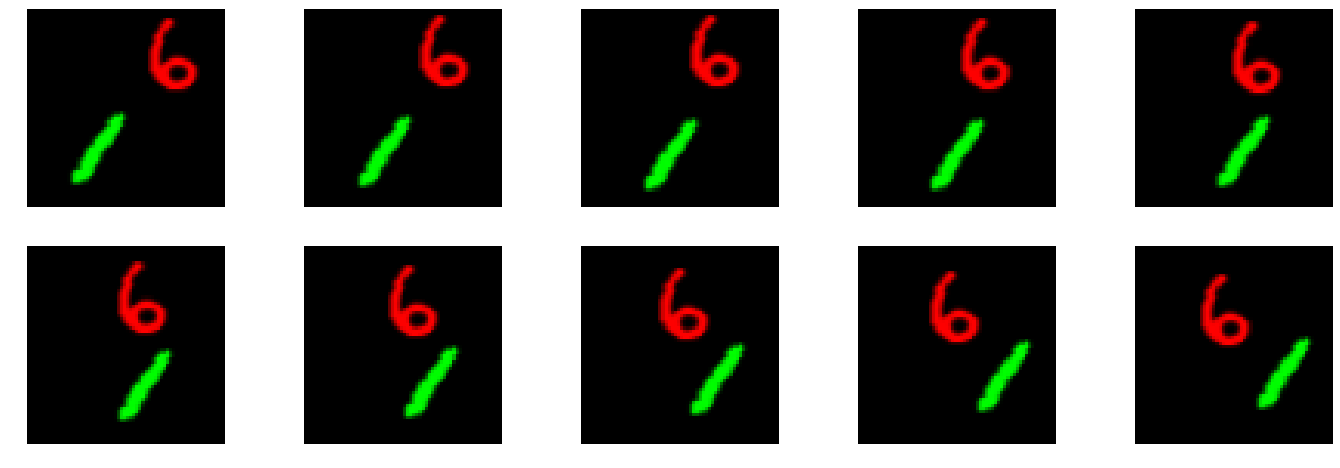

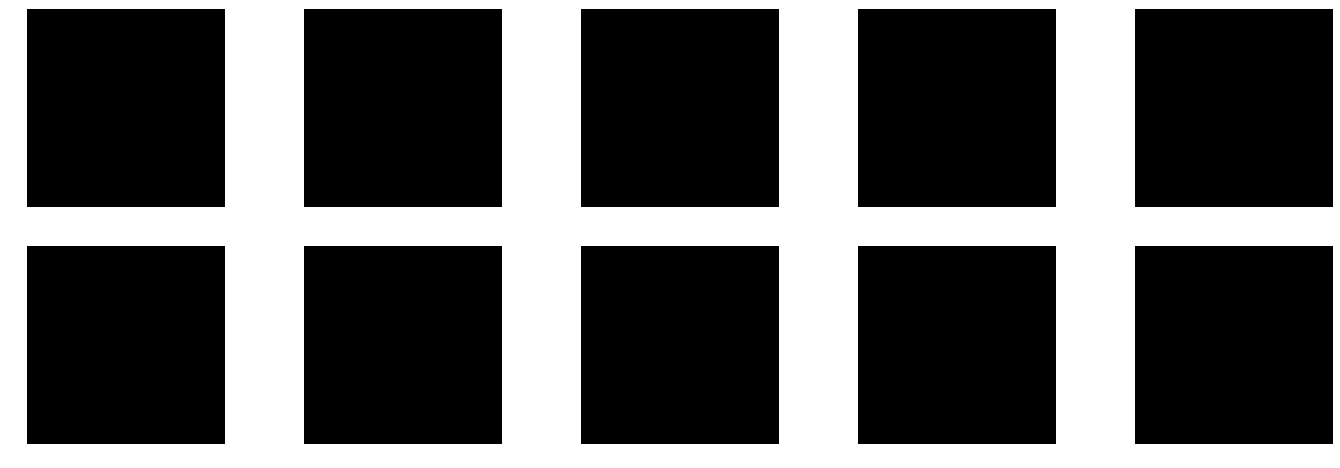

In [23]:
epochs = 1
batch_size = 200

initial_epoch = 0

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [24]:
opt = optimizers.Adam(lr = 2e-3, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 2/5
100/100 [==============================] - 419s 4s/step - loss: 7.9262e-04 - mean_squared_error: 6.4374e-04 - val_loss: 6.9503e-04 - val_mean_squared_error: 6.3672e-04

Epoch 00002: saving model to ./models/model0616_256.hdf5
Epoch 3/5
100/100 [==============================] - 415s 4s/step - loss: 6.5249e-04 - mean_squared_error: 6.2638e-04 - val_loss: 6.1819e-04 - val_mean_squared_error: 6.0710e-04

Epoch 00003: saving model to ./models/model0616_256.hdf5
Epoch 4/5
100/100 [==============================] - 414s 4s/step - loss: 6.1231e-04 - mean_squared_error: 6.0314e-04 - val_loss: 5.9369e-04 - val_mean_squared_error: 5.8526e-04

Epoch 00004: saving model to ./models/model0616_256.hdf5
Epoch 5/5
100/100 [==============================] - 414s 4s/step - loss: 5.8854e-04 - mean_squared_error: 5.7975e-04 - val_loss: 5.6262e-04 - val_mean_squared_error: 5.5330e-04

Epoch 00005: saving model to ./models/model0616_256.hdf5


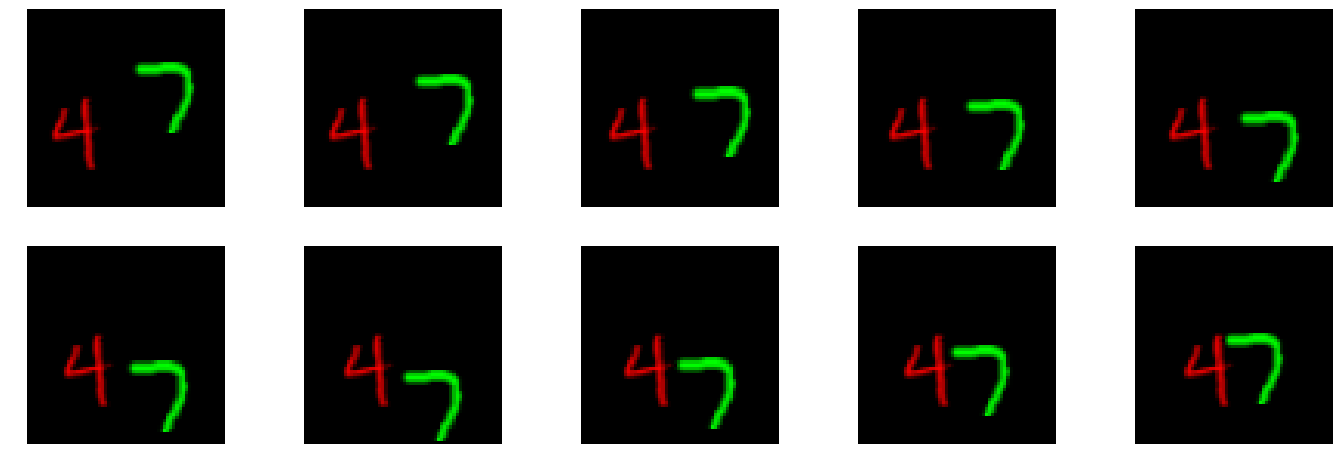

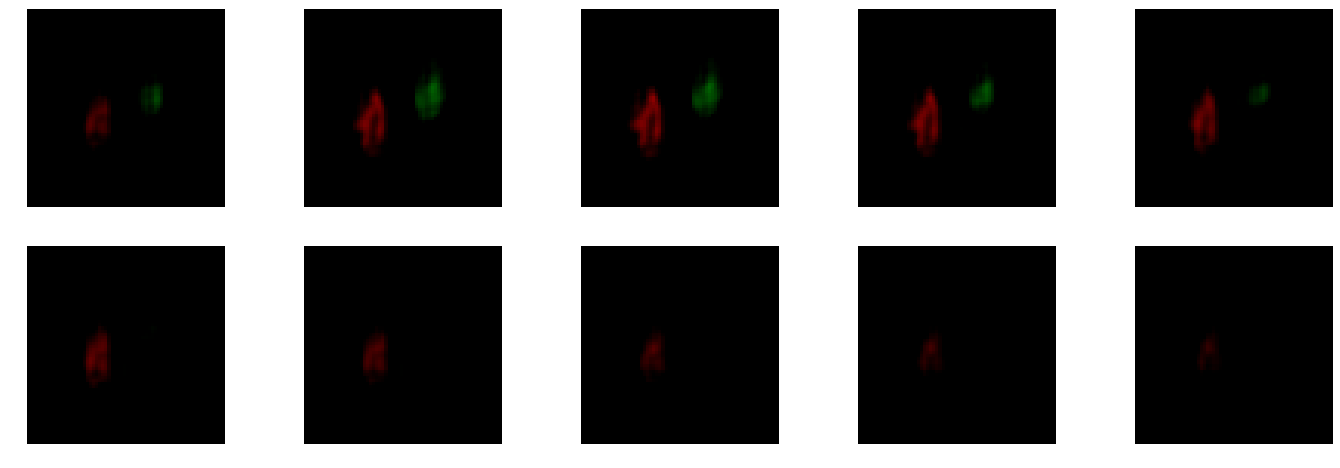

In [25]:
epochs = 5
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 6/20
100/100 [==============================] - 413s 4s/step - loss: 5.5926e-04 - mean_squared_error: 5.4938e-04 - val_loss: 5.3310e-04 - val_mean_squared_error: 5.2242e-04

Epoch 00006: saving model to ./models/model0616_256.hdf5
Epoch 7/20
100/100 [==============================] - 412s 4s/step - loss: 5.2862e-04 - mean_squared_error: 5.1725e-04 - val_loss: 4.9602e-04 - val_mean_squared_error: 4.8420e-04

Epoch 00007: saving model to ./models/model0616_256.hdf5
Epoch 8/20
100/100 [==============================] - 412s 4s/step - loss: 4.9599e-04 - mean_squared_error: 4.8362e-04 - val_loss: 4.6388e-04 - val_mean_squared_error: 4.5105e-04

Epoch 00008: saving model to ./models/model0616_256.hdf5
Epoch 9/20
100/100 [==============================] - 413s 4s/step - loss: 4.6483e-04 - mean_squared_error: 4.5154e-04 - val_loss: 4.2928e-04 - val_mean_squared_error: 4.1564e-04

Epoch 00009: saving model to ./models/model0616_256.hdf5
Epoch 10/20
100/100 [==============================]

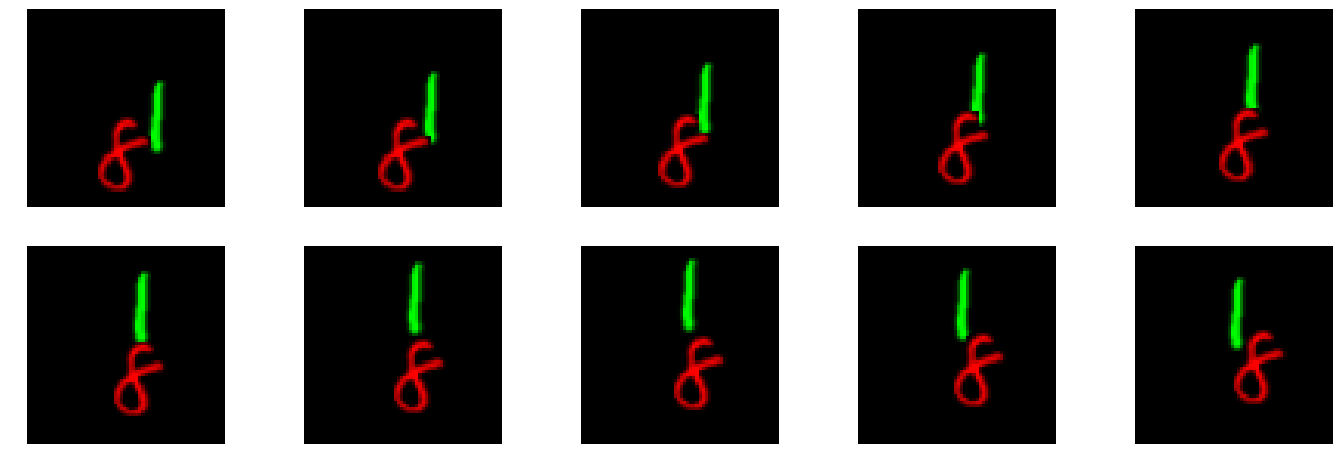

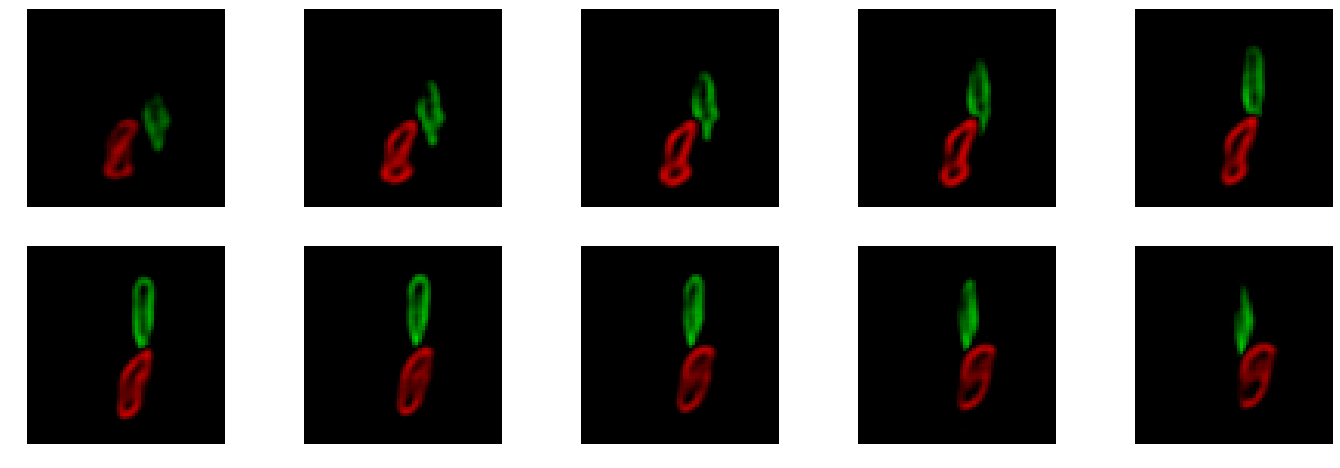

In [26]:
epochs = 20
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 21/40
100/100 [==============================] - 416s 4s/step - loss: 2.6346e-04 - mean_squared_error: 2.5275e-04 - val_loss: 2.8274e-04 - val_mean_squared_error: 2.7198e-04

Epoch 00021: saving model to ./models/model0616_U.hdf5
Epoch 22/40
100/100 [==============================] - 414s 4s/step - loss: 2.6189e-04 - mean_squared_error: 2.5117e-04 - val_loss: 2.7950e-04 - val_mean_squared_error: 2.6878e-04

Epoch 00022: saving model to ./models/model0616_U.hdf5
Epoch 23/40
100/100 [==============================] - 412s 4s/step - loss: 2.5914e-04 - mean_squared_error: 2.4843e-04 - val_loss: 2.8064e-04 - val_mean_squared_error: 2.6991e-04

Epoch 00023: saving model to ./models/model0616_U.hdf5
Epoch 24/40
100/100 [==============================] - 412s 4s/step - loss: 2.5614e-04 - mean_squared_error: 2.4541e-04 - val_loss: 2.7855e-04 - val_mean_squared_error: 2.6790e-04

Epoch 00024: saving model to ./models/model0616_U.hdf5
Epoch 25/40
100/100 [==============================] - 4

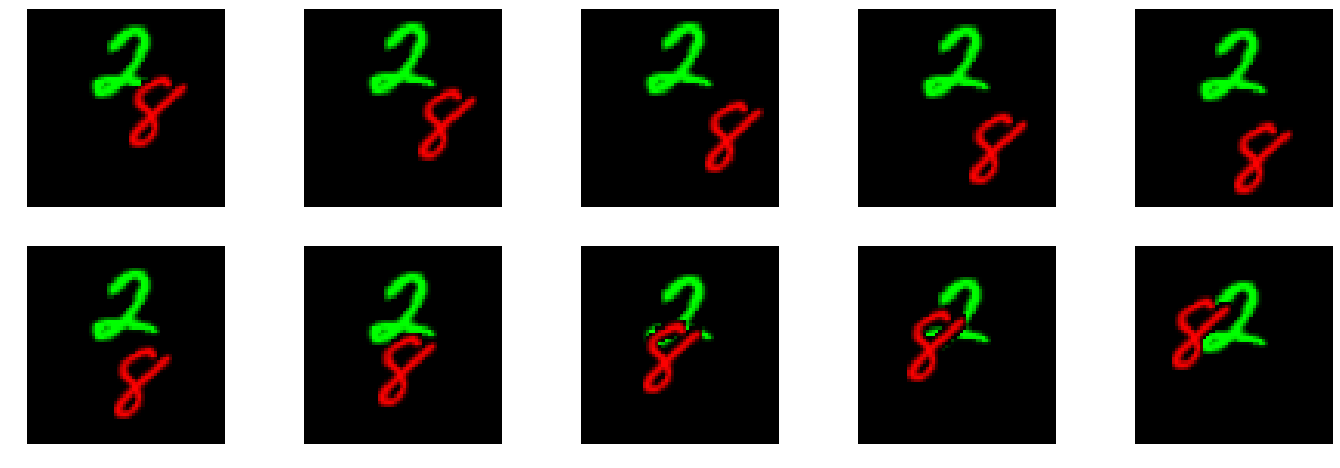

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


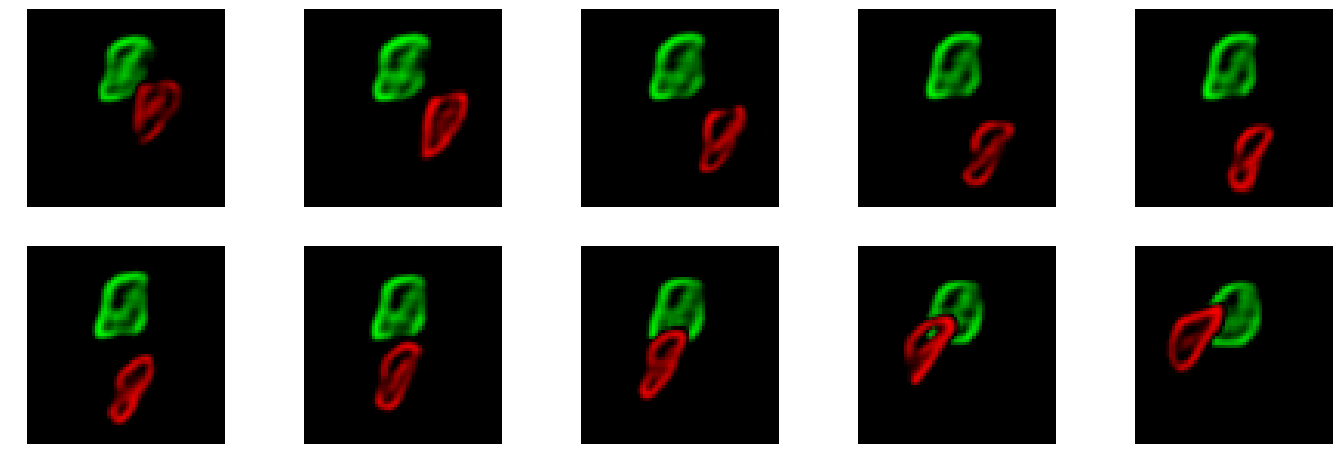

In [34]:
epochs = 40
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 41/50
100/100 [==============================] - 409s 4s/step - loss: 2.2906e-04 - mean_squared_error: 2.1868e-04 - val_loss: 2.6216e-04 - val_mean_squared_error: 2.5174e-04

Epoch 00041: saving model to ./models/model0616_U.hdf5
Epoch 42/50
100/100 [==============================] - 408s 4s/step - loss: 2.2716e-04 - mean_squared_error: 2.1673e-04 - val_loss: 2.5920e-04 - val_mean_squared_error: 2.4877e-04

Epoch 00042: saving model to ./models/model0616_U.hdf5
Epoch 43/50
100/100 [==============================] - 408s 4s/step - loss: 2.2612e-04 - mean_squared_error: 2.1574e-04 - val_loss: 2.5874e-04 - val_mean_squared_error: 2.4834e-04

Epoch 00043: saving model to ./models/model0616_U.hdf5
Epoch 44/50
100/100 [==============================] - 408s 4s/step - loss: 2.2570e-04 - mean_squared_error: 2.1527e-04 - val_loss: 2.5610e-04 - val_mean_squared_error: 2.4562e-04

Epoch 00044: saving model to ./models/model0616_U.hdf5
Epoch 45/50
100/100 [==============================] - 4

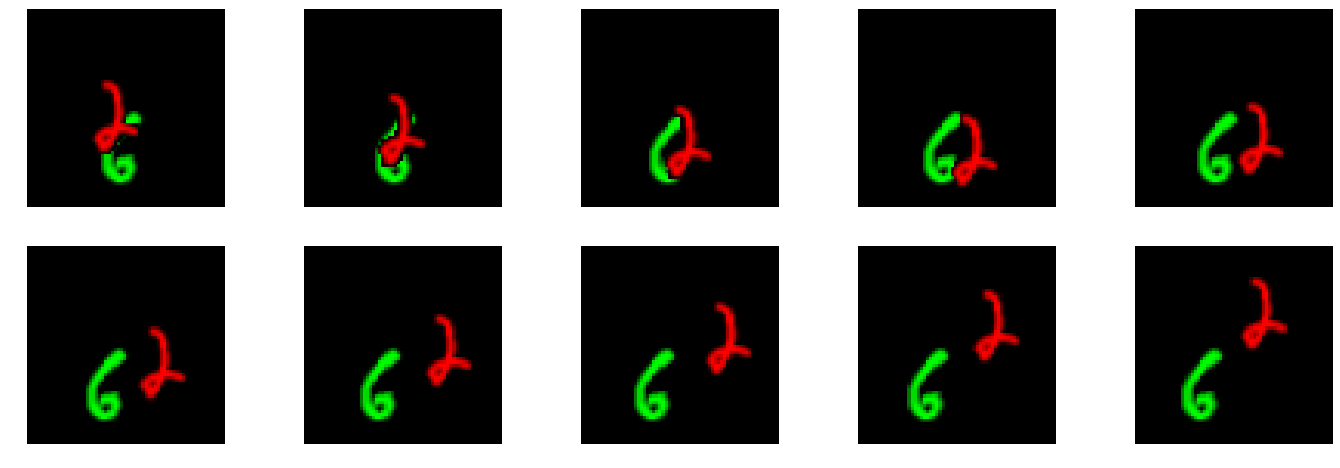

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


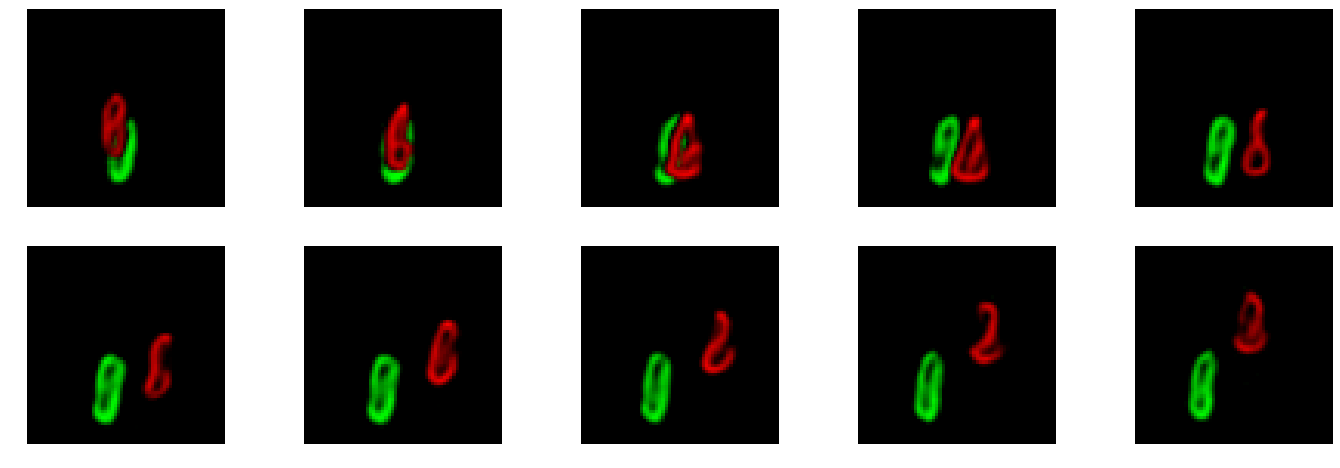

In [35]:
epochs = 50
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 51/60
100/100 [==============================] - 408s 4s/step - loss: 2.1522e-04 - mean_squared_error: 2.0489e-04 - val_loss: 2.5067e-04 - val_mean_squared_error: 2.4032e-04

Epoch 00051: saving model to ./models/model0616_U.hdf5
Epoch 52/60
100/100 [==============================] - 406s 4s/step - loss: 2.1427e-04 - mean_squared_error: 2.0393e-04 - val_loss: 2.4985e-04 - val_mean_squared_error: 2.3958e-04

Epoch 00052: saving model to ./models/model0616_U.hdf5
Epoch 53/60
100/100 [==============================] - 406s 4s/step - loss: 2.1295e-04 - mean_squared_error: 2.0264e-04 - val_loss: 2.5125e-04 - val_mean_squared_error: 2.4094e-04

Epoch 00053: saving model to ./models/model0616_U.hdf5
Epoch 54/60
100/100 [==============================] - 407s 4s/step - loss: 2.1188e-04 - mean_squared_error: 2.0158e-04 - val_loss: 2.5109e-04 - val_mean_squared_error: 2.4078e-04

Epoch 00054: saving model to ./models/model0616_U.hdf5
Epoch 55/60
100/100 [==============================] - 4

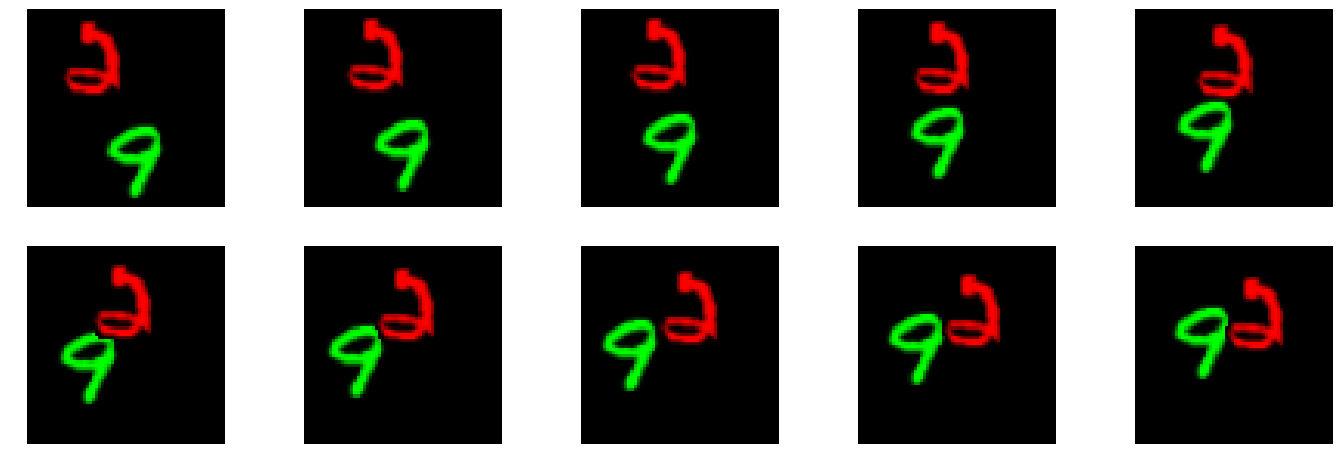

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


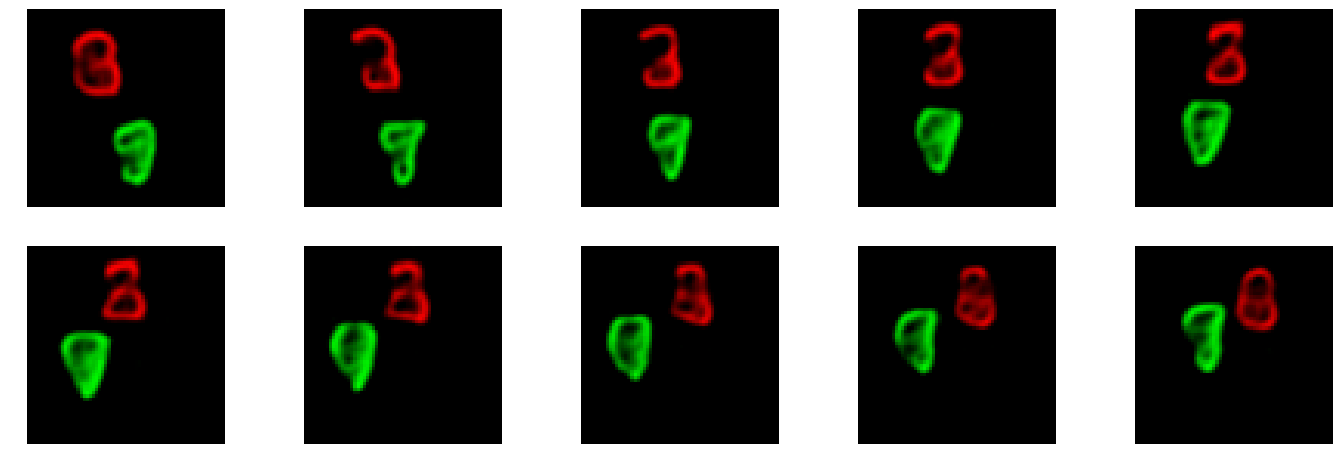

In [36]:
epochs = 60
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 61/70
100/100 [==============================] - 410s 4s/step - loss: 2.0421e-04 - mean_squared_error: 1.9395e-04 - val_loss: 2.4557e-04 - val_mean_squared_error: 2.3533e-04

Epoch 00061: saving model to ./models/model0616_U.hdf5
Epoch 62/70
100/100 [==============================] - 407s 4s/step - loss: 2.0379e-04 - mean_squared_error: 1.9355e-04 - val_loss: 2.4271e-04 - val_mean_squared_error: 2.3248e-04

Epoch 00062: saving model to ./models/model0616_U.hdf5
Epoch 63/70
100/100 [==============================] - 410s 4s/step - loss: 2.0277e-04 - mean_squared_error: 1.9255e-04 - val_loss: 2.4667e-04 - val_mean_squared_error: 2.3643e-04

Epoch 00063: saving model to ./models/model0616_U.hdf5
Epoch 64/70
100/100 [==============================] - 409s 4s/step - loss: 2.0044e-04 - mean_squared_error: 1.9019e-04 - val_loss: 2.4088e-04 - val_mean_squared_error: 2.3068e-04

Epoch 00064: saving model to ./models/model0616_U.hdf5
Epoch 65/70
100/100 [==============================] - 4

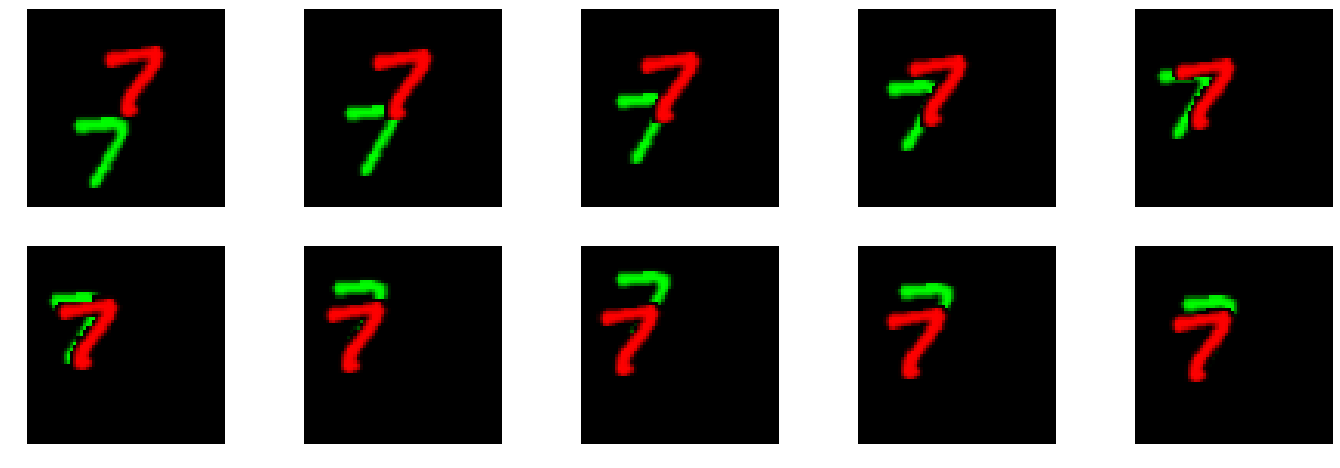

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


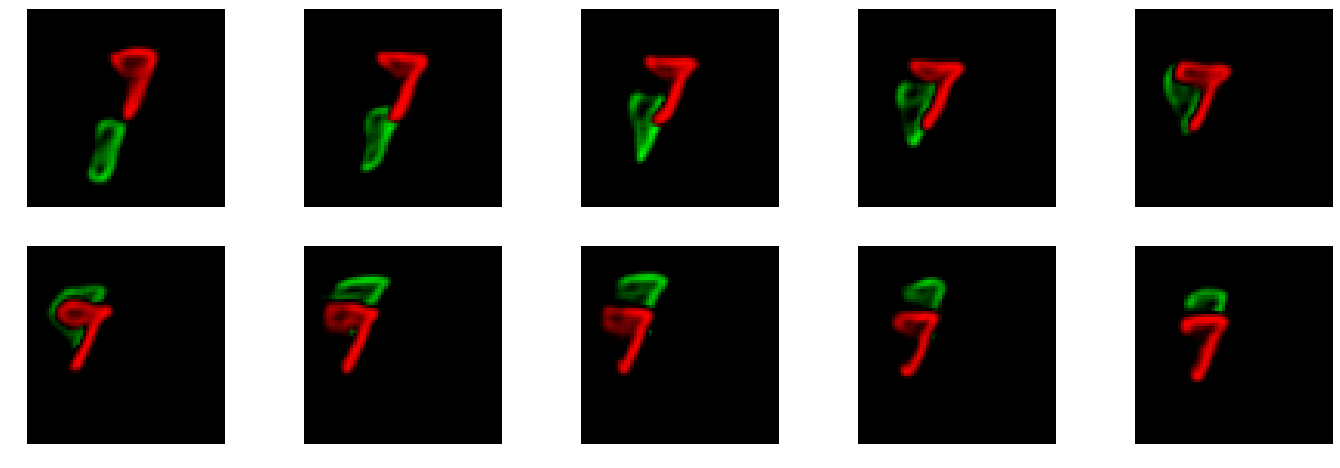

In [37]:
epochs = 70
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 71/80
100/100 [==============================] - 411s 4s/step - loss: 1.9569e-04 - mean_squared_error: 1.8553e-04 - val_loss: 2.4151e-04 - val_mean_squared_error: 2.3131e-04

Epoch 00071: val_loss improved from inf to 0.00024, saving model to ./models/model0616_U.hdf5
Epoch 72/80
100/100 [==============================] - 409s 4s/step - loss: 1.9485e-04 - mean_squared_error: 1.8468e-04 - val_loss: 2.3914e-04 - val_mean_squared_error: 2.2898e-04

Epoch 00072: val_loss improved from 0.00024 to 0.00024, saving model to ./models/model0616_U.hdf5
Epoch 73/80
100/100 [==============================] - 409s 4s/step - loss: 1.9477e-04 - mean_squared_error: 1.8461e-04 - val_loss: 2.3843e-04 - val_mean_squared_error: 2.2825e-04

Epoch 00073: val_loss improved from 0.00024 to 0.00024, saving model to ./models/model0616_U.hdf5
Epoch 74/80
100/100 [==============================] - 411s 4s/step - loss: 1.9271e-04 - mean_squared_error: 1.8257e-04 - val_loss: 2.3683e-04 - val_mean_squared_error

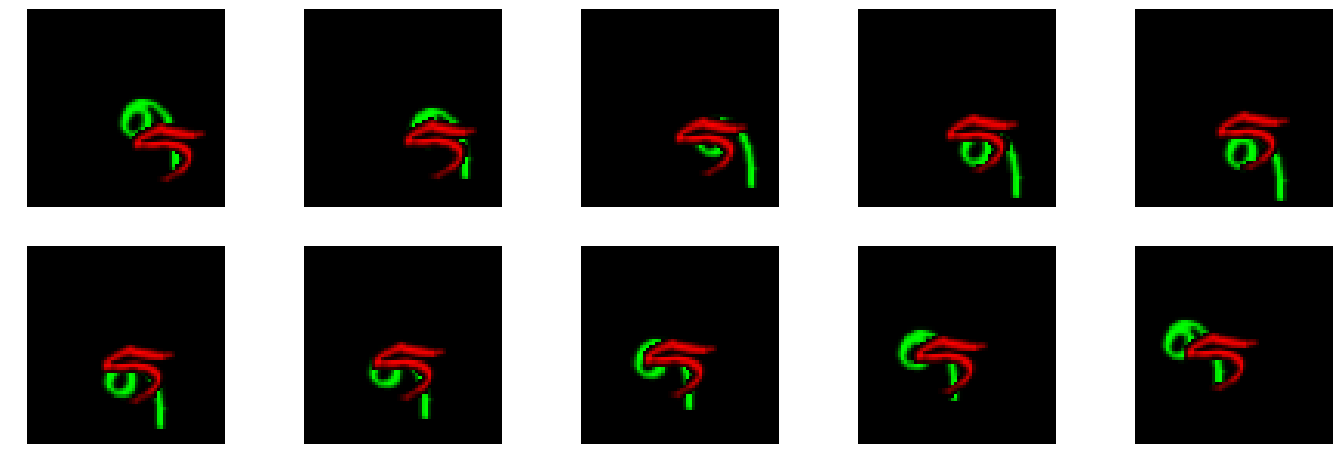

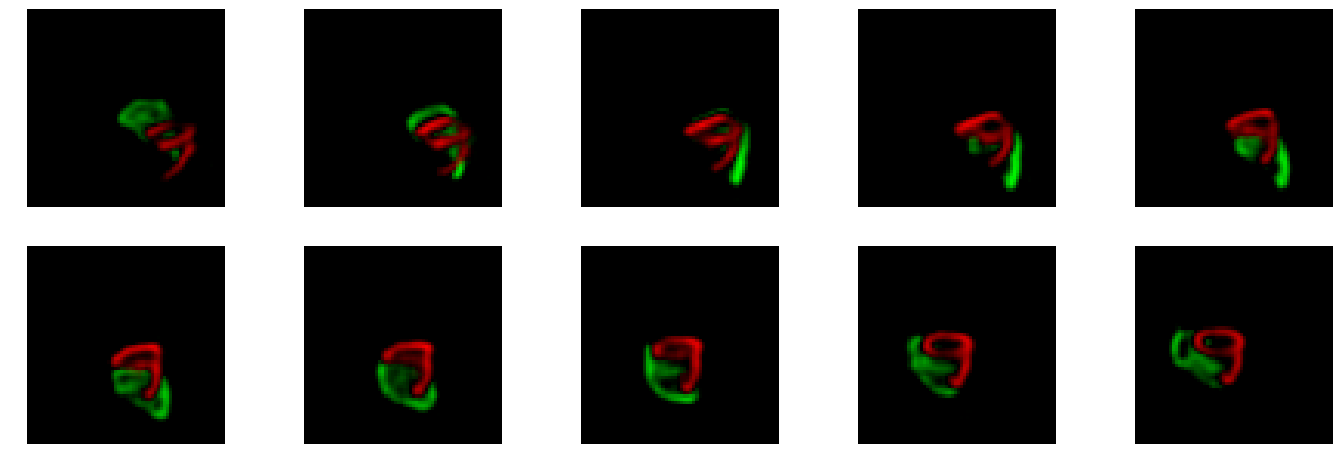

In [38]:
epochs = 80
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [40]:
opt = optimizers.Adam(lr = 1e-3, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 81/100
100/100 [==============================] - 420s 4s/step - loss: 1.7221e-04 - mean_squared_error: 1.6262e-04 - val_loss: 2.1962e-04 - val_mean_squared_error: 2.1050e-04

Epoch 00081: val_loss improved from inf to 0.00022, saving model to ./models/model0616_U.hdf5
Epoch 82/100
100/100 [==============================] - 416s 4s/step - loss: 1.6934e-04 - mean_squared_error: 1.6047e-04 - val_loss: 2.1983e-04 - val_mean_squared_error: 2.1116e-04

Epoch 00082: val_loss did not improve from 0.00022
Epoch 83/100
100/100 [==============================] - 415s 4s/step - loss: 1.6873e-04 - mean_squared_error: 1.6017e-04 - val_loss: 2.2041e-04 - val_mean_squared_error: 2.1194e-04

Epoch 00083: val_loss did not improve from 0.00022
Epoch 84/100
100/100 [==============================] - 416s 4s/step - loss: 1.6793e-04 - mean_squared_error: 1.5952e-04 - val_loss: 2.2040e-04 - val_mean_squared_error: 2.1205e-04

Epoch 00084: val_loss did not improve from 0.00022
Epoch 85/100
100/100 [===

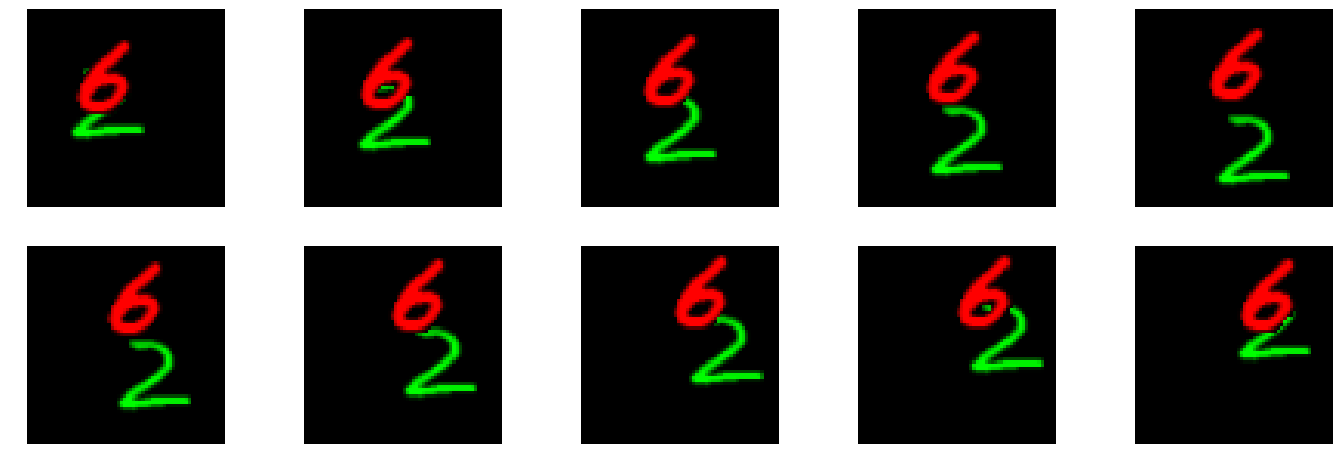

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


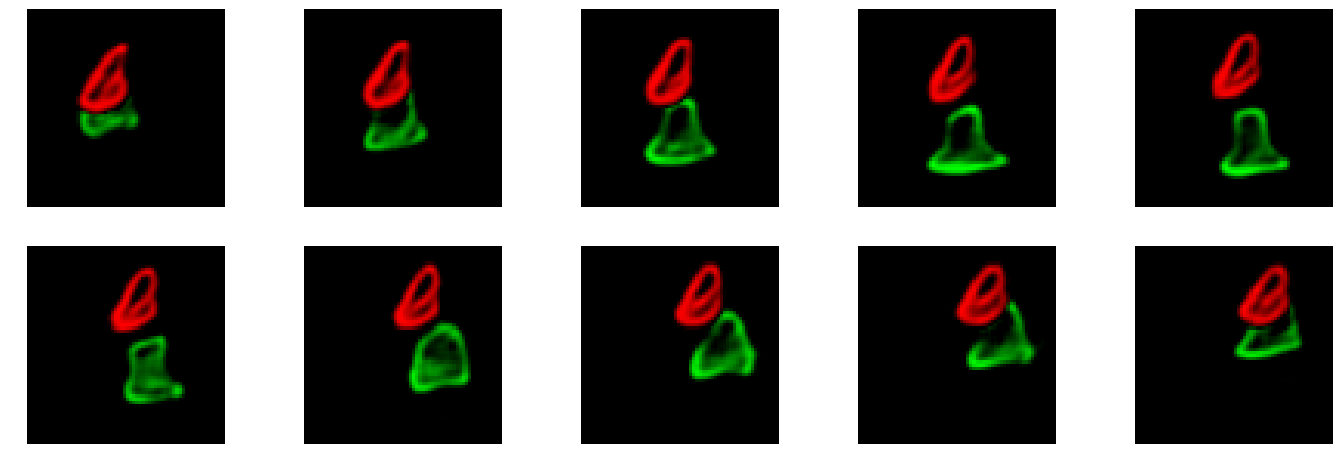

In [41]:
epochs = 100
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 101/150
100/100 [==============================] - 412s 4s/step - loss: 2.4659e-04 - mean_squared_error: 2.3913e-04 - val_loss: 2.3702e-04 - val_mean_squared_error: 2.2959e-04

Epoch 00101: val_loss improved from inf to 0.00024, saving model to ./models/model0616_U.hdf5
Epoch 102/150
100/100 [==============================] - 412s 4s/step - loss: 2.3791e-04 - mean_squared_error: 2.3046e-04 - val_loss: 2.3265e-04 - val_mean_squared_error: 2.2519e-04

Epoch 00102: val_loss improved from 0.00024 to 0.00023, saving model to ./models/model0616_U.hdf5
Epoch 103/150
100/100 [==============================] - 412s 4s/step - loss: 2.3394e-04 - mean_squared_error: 2.2646e-04 - val_loss: 2.3450e-04 - val_mean_squared_error: 2.2698e-04

Epoch 00103: val_loss did not improve from 0.00023
Epoch 104/150
100/100 [==============================] - 412s 4s/step - loss: 2.3272e-04 - mean_squared_error: 2.2517e-04 - val_loss: 2.2921e-04 - val_mean_squared_error: 2.2164e-04

Epoch 00104: val_loss imp

100/100 [==============================] - 416s 4s/step - loss: 2.0580e-04 - mean_squared_error: 1.9810e-04 - val_loss: 2.1951e-04 - val_mean_squared_error: 2.1180e-04

Epoch 00134: val_loss did not improve from 0.00022
Epoch 135/150
100/100 [==============================] - 415s 4s/step - loss: 2.0456e-04 - mean_squared_error: 1.9683e-04 - val_loss: 2.2078e-04 - val_mean_squared_error: 2.1305e-04

Epoch 00135: val_loss did not improve from 0.00022
Epoch 136/150
100/100 [==============================] - 416s 4s/step - loss: 2.0615e-04 - mean_squared_error: 1.9840e-04 - val_loss: 2.2158e-04 - val_mean_squared_error: 2.1385e-04

Epoch 00136: val_loss did not improve from 0.00022
Epoch 137/150
100/100 [==============================] - 416s 4s/step - loss: 2.0453e-04 - mean_squared_error: 1.9681e-04 - val_loss: 2.2107e-04 - val_mean_squared_error: 2.1336e-04

Epoch 00137: val_loss did not improve from 0.00022
Epoch 138/150
100/100 [==============================] - 416s 4s/step - loss: 

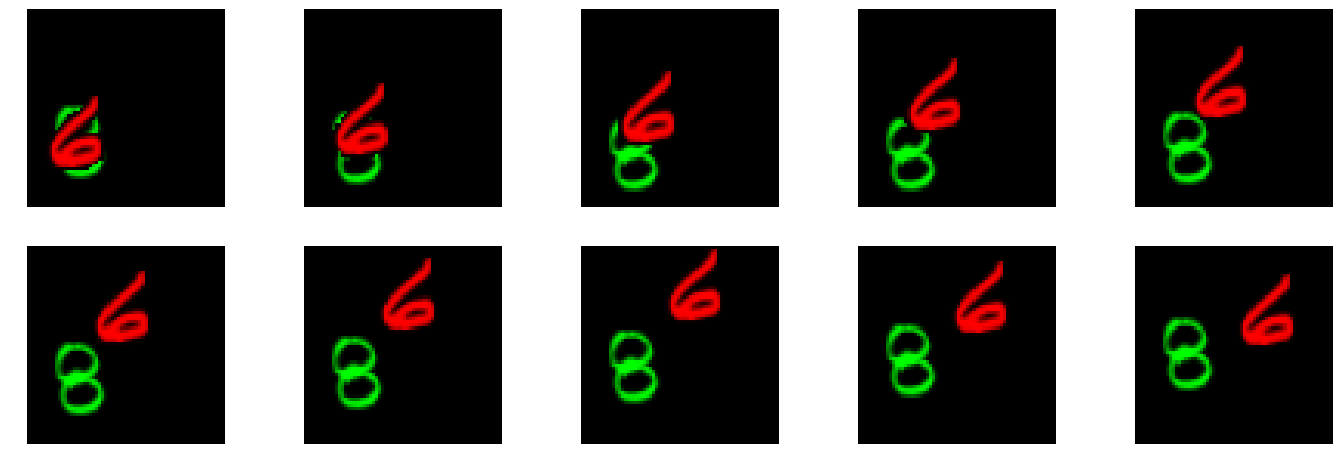

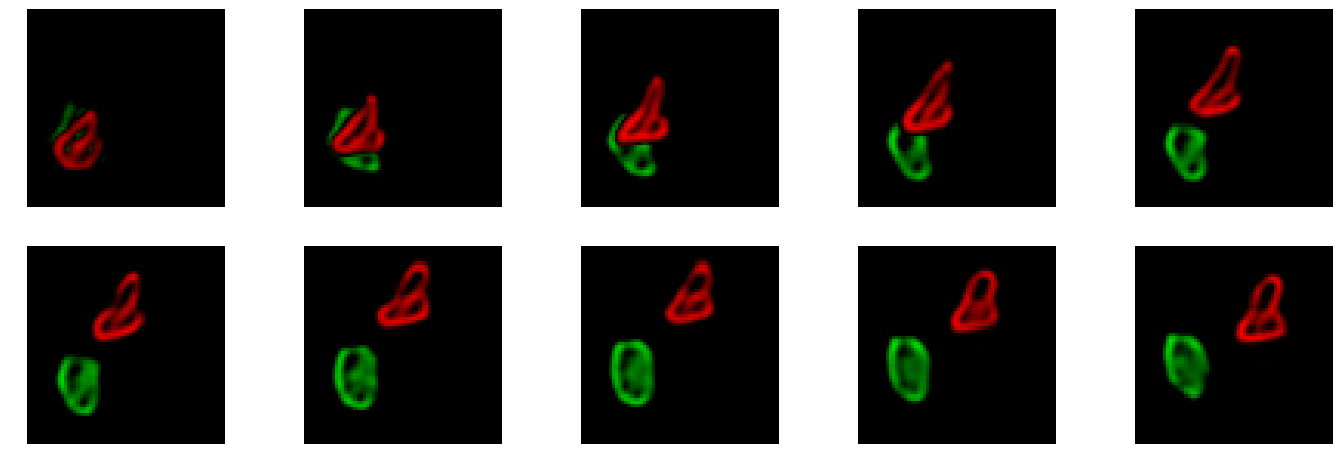

In [44]:
epochs = 150
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = True, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [48]:
opt = optimizers.Adam(lr = 5e-4, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 151/170
100/100 [==============================] - 428s 4s/step - loss: 1.8767e-04 - mean_squared_error: 1.8014e-04 - val_loss: 2.0759e-04 - val_mean_squared_error: 2.0025e-04

Epoch 00151: saving model to ./models/model0616_U.hdf5
Epoch 152/170
100/100 [==============================] - 420s 4s/step - loss: 1.8525e-04 - mean_squared_error: 1.7806e-04 - val_loss: 2.0789e-04 - val_mean_squared_error: 2.0083e-04

Epoch 00152: saving model to ./models/model0616_U.hdf5
Epoch 153/170
100/100 [==============================] - 420s 4s/step - loss: 1.8572e-04 - mean_squared_error: 1.7874e-04 - val_loss: 2.0806e-04 - val_mean_squared_error: 2.0115e-04

Epoch 00153: saving model to ./models/model0616_U.hdf5
Epoch 154/170
100/100 [==============================] - 419s 4s/step - loss: 1.8595e-04 - mean_squared_error: 1.7909e-04 - val_loss: 2.0948e-04 - val_mean_squared_error: 2.0266e-04

Epoch 00154: saving model to ./models/model0616_U.hdf5
Epoch 155/170
100/100 [=========================

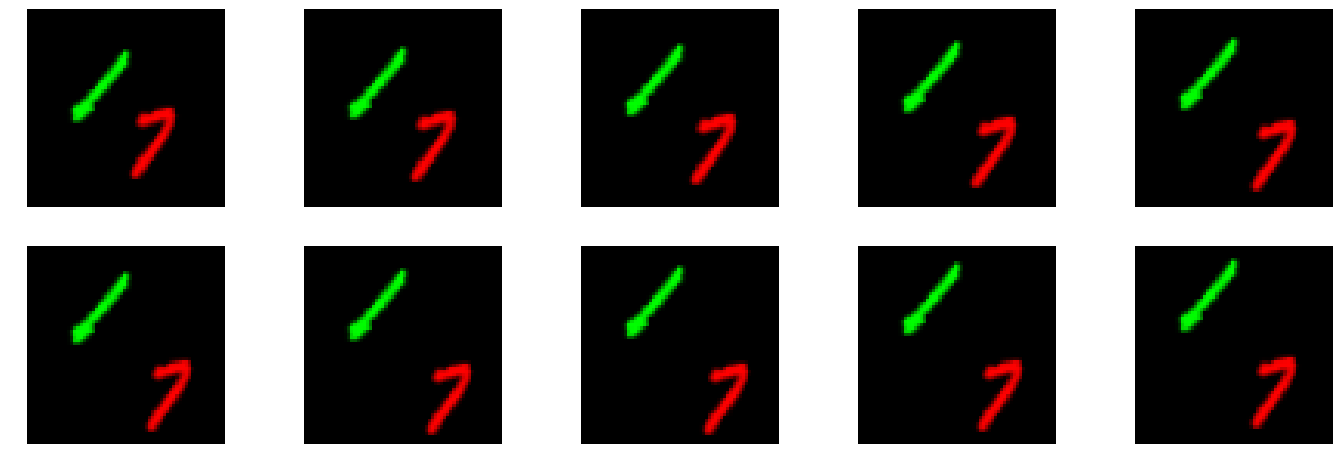

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


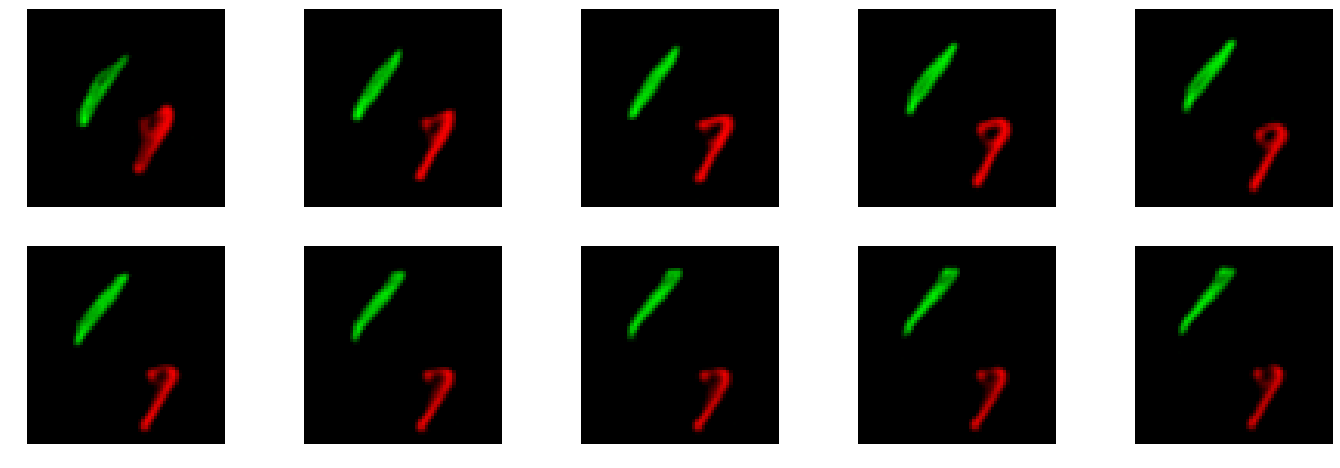

In [49]:
epochs = 170
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 171/200
100/100 [==============================] - 413s 4s/step - loss: 1.8248e-04 - mean_squared_error: 1.7615e-04 - val_loss: 2.0819e-04 - val_mean_squared_error: 2.0186e-04

Epoch 00171: saving model to ./models/model0616_U.hdf5
Epoch 172/200
100/100 [==============================] - 415s 4s/step - loss: 1.8240e-04 - mean_squared_error: 1.7608e-04 - val_loss: 2.0709e-04 - val_mean_squared_error: 2.0077e-04

Epoch 00172: saving model to ./models/model0616_U.hdf5
Epoch 173/200
100/100 [==============================] - 412s 4s/step - loss: 1.8161e-04 - mean_squared_error: 1.7531e-04 - val_loss: 2.0781e-04 - val_mean_squared_error: 2.0151e-04

Epoch 00173: saving model to ./models/model0616_U.hdf5
Epoch 174/200
100/100 [==============================] - 412s 4s/step - loss: 1.8239e-04 - mean_squared_error: 1.7610e-04 - val_loss: 2.0990e-04 - val_mean_squared_error: 2.0361e-04

Epoch 00174: saving model to ./models/model0616_U.hdf5
Epoch 175/200
100/100 [=========================

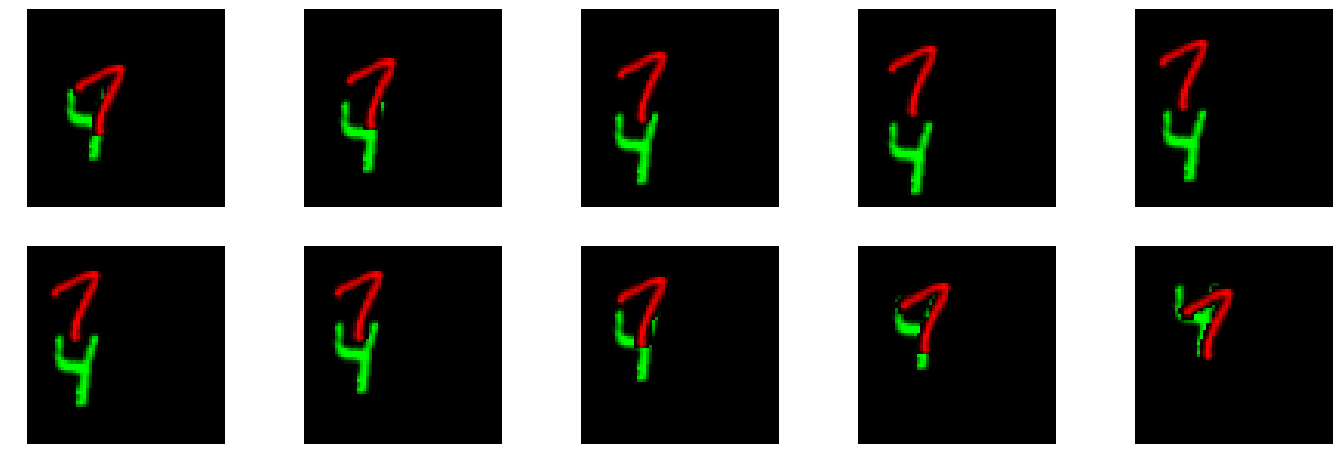

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


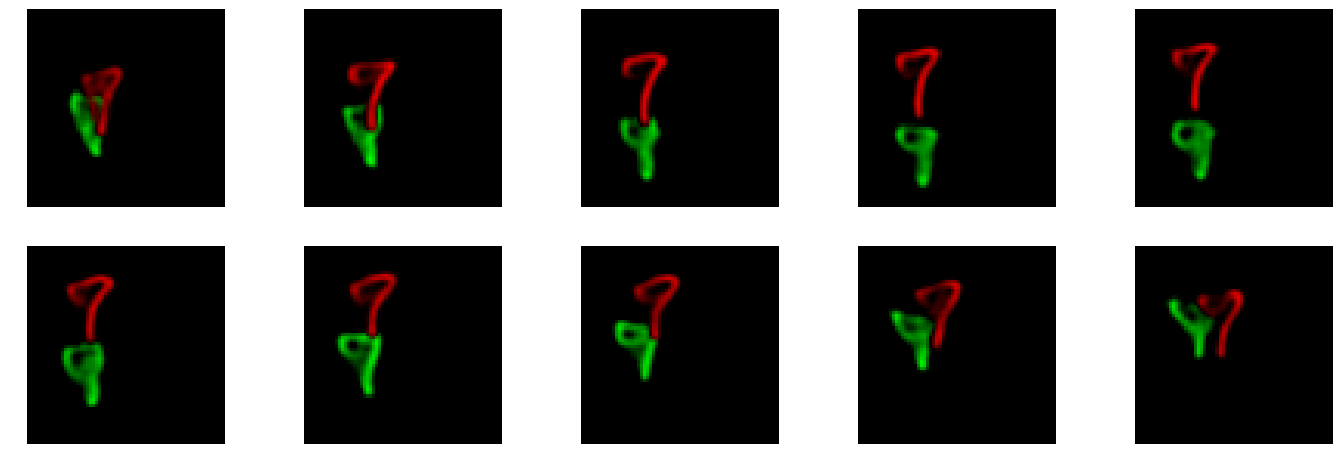

In [52]:
epochs = 200
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 201/240
100/100 [==============================] - 423s 4s/step - loss: 1.7680e-04 - mean_squared_error: 1.7077e-04 - val_loss: 2.0759e-04 - val_mean_squared_error: 2.0158e-04

Epoch 00201: saving model to ./models/model0616_U.hdf5
Epoch 202/240
100/100 [==============================] - 420s 4s/step - loss: 1.7615e-04 - mean_squared_error: 1.7013e-04 - val_loss: 2.0788e-04 - val_mean_squared_error: 2.0188e-04

Epoch 00202: saving model to ./models/model0616_U.hdf5
Epoch 203/240
100/100 [==============================] - 420s 4s/step - loss: 1.7675e-04 - mean_squared_error: 1.7074e-04 - val_loss: 2.0713e-04 - val_mean_squared_error: 2.0113e-04

Epoch 00203: saving model to ./models/model0616_U.hdf5
Epoch 204/240
100/100 [==============================] - 421s 4s/step - loss: 1.7665e-04 - mean_squared_error: 1.7065e-04 - val_loss: 2.0666e-04 - val_mean_squared_error: 2.0066e-04

Epoch 00204: saving model to ./models/model0616_U.hdf5
Epoch 205/240
100/100 [=========================

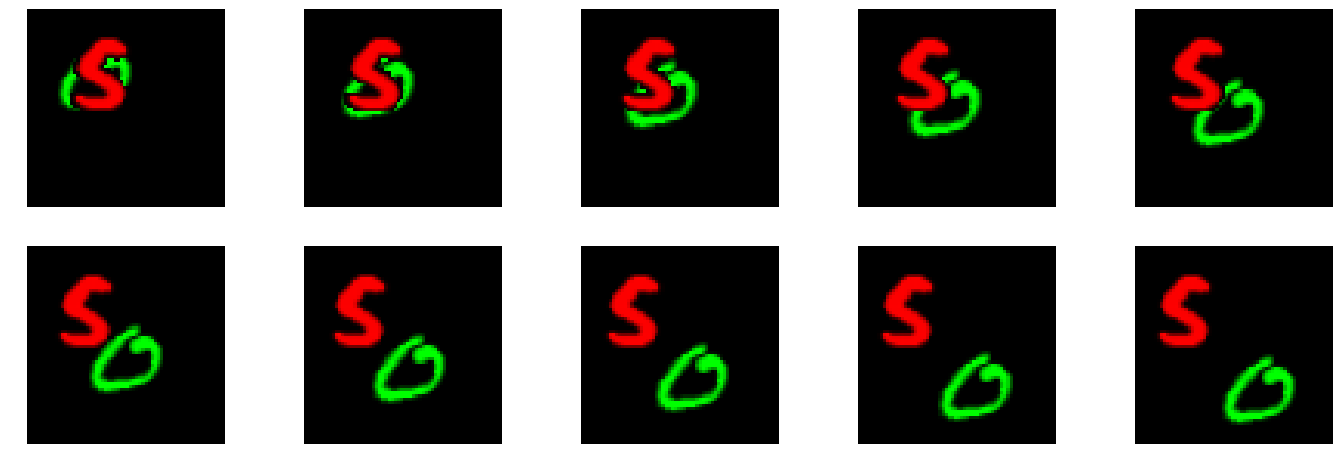

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

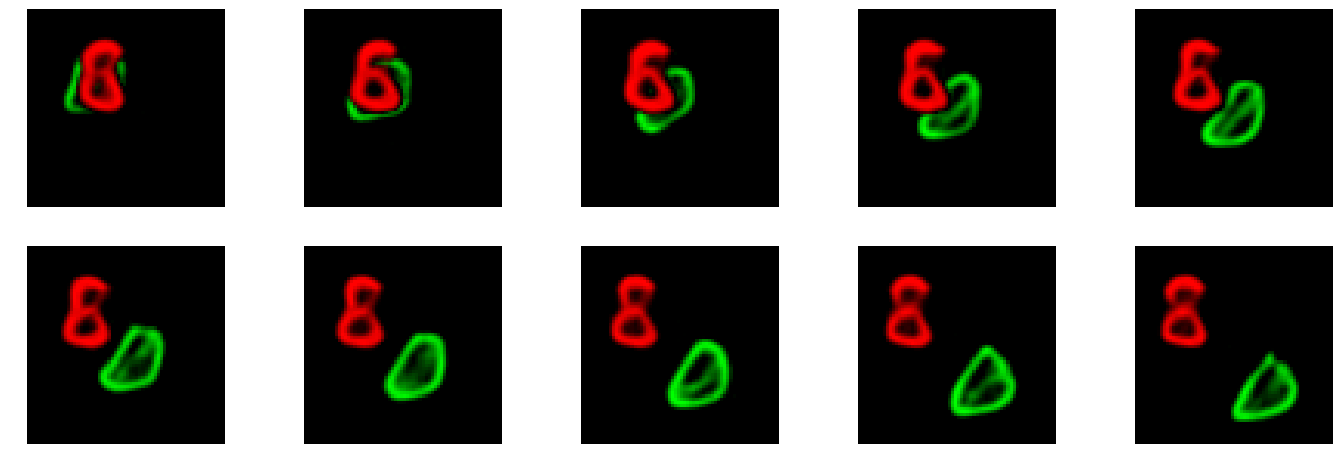

In [55]:
epochs = 240
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [60]:
opt = optimizers.Adam(lr = 2e-4, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

In [ ]:
epochs = 270
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_U.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 241/270
100/100 [==============================] - 449s 4s/step - loss: 1.6296e-04 - mean_squared_error: 1.5718e-04 - val_loss: 1.9907e-04 - val_mean_squared_error: 1.9335e-04

Epoch 00241: saving model to ./models/model0616_U.hdf5
Epoch 242/270
100/100 [==============================] - 432s 4s/step - loss: 1.6173e-04 - mean_squared_error: 1.5607e-04 - val_loss: 1.9835e-04 - val_mean_squared_error: 1.9274e-04

Epoch 00242: saving model to ./models/model0616_U.hdf5
Epoch 243/270
100/100 [==============================] - 426s 4s/step - loss: 1.6127e-04 - mean_squared_error: 1.5571e-04 - val_loss: 1.9775e-04 - val_mean_squared_error: 1.9224e-04

Epoch 00243: saving model to ./models/model0616_U.hdf5
Epoch 244/270
100/100 [==============================] - 435s 4s/step - loss: 1.6136e-04 - mean_squared_error: 1.5588e-04 - val_loss: 1.9859e-04 - val_mean_squared_error: 1.9315e-04

Epoch 00244: saving model to ./models/model0616_U.hdf5
Epoch 245/270
100/100 [=========================

In [6]:
model = load_model('./models/model0616_U.hdf5')
opt = optimizers.Adam(lr = 1e-4, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Instructions for updating:
Use tf.cast instead.


Epoch 1/1
100/100 [==============================] - 1025s 10s/step - loss: 1.5582e-04 - mean_squared_error: 1.5090e-04 - val_loss: 1.9529e-04 - val_mean_squared_error: 1.9038e-04

Epoch 00001: saving model to ./models/model0616_256.hdf5


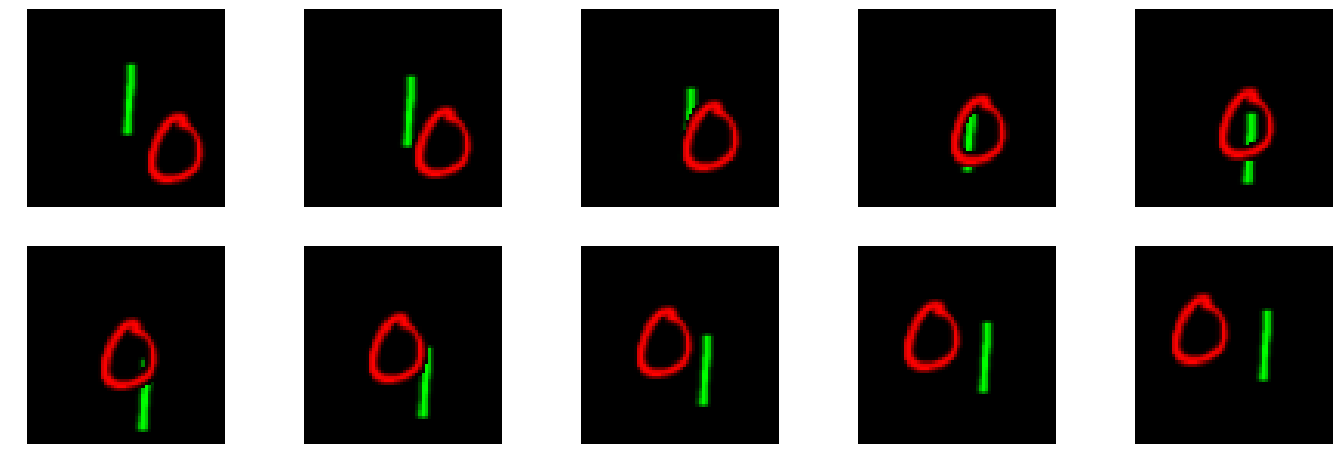

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


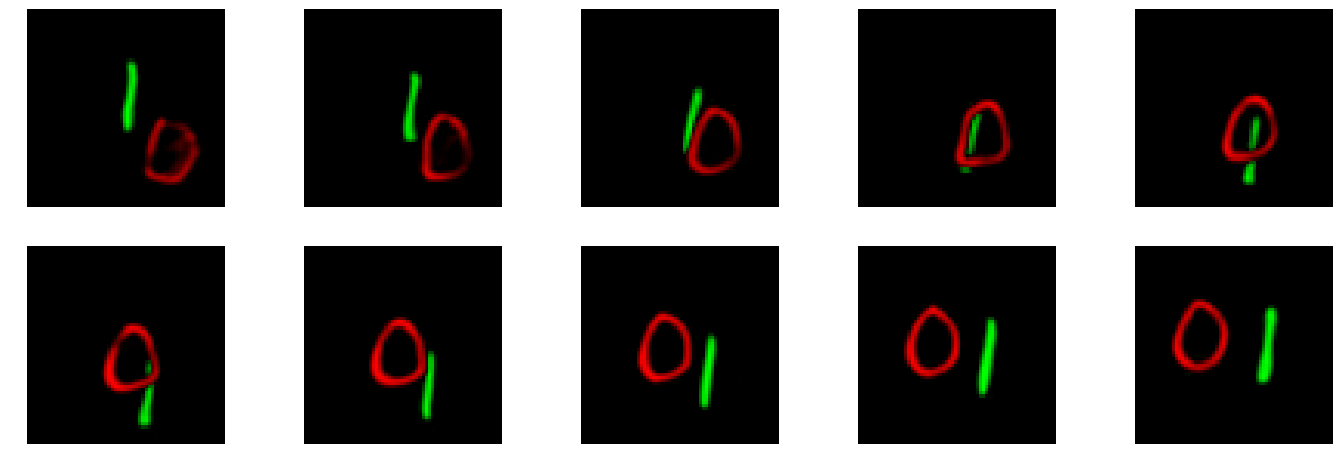

In [7]:
initial_epoch = 0

epochs = 1
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 2/10
100/100 [==============================] - 504s 5s/step - loss: 1.5573e-04 - mean_squared_error: 1.5084e-04 - val_loss: 1.9642e-04 - val_mean_squared_error: 1.9154e-04

Epoch 00002: saving model to ./models/model0616_256.hdf5
Epoch 3/10
100/100 [==============================] - 429s 4s/step - loss: 1.5541e-04 - mean_squared_error: 1.5055e-04 - val_loss: 1.9521e-04 - val_mean_squared_error: 1.9036e-04

Epoch 00003: saving model to ./models/model0616_256.hdf5
Epoch 4/10
100/100 [==============================] - 419s 4s/step - loss: 1.5622e-04 - mean_squared_error: 1.5138e-04 - val_loss: 1.9492e-04 - val_mean_squared_error: 1.9010e-04

Epoch 00004: saving model to ./models/model0616_256.hdf5
Epoch 5/10
100/100 [==============================] - 418s 4s/step - loss: 1.5583e-04 - mean_squared_error: 1.5102e-04 - val_loss: 1.9602e-04 - val_mean_squared_error: 1.9122e-04

Epoch 00005: saving model to ./models/model0616_256.hdf5
Epoch 6/10
100/100 [==============================] 

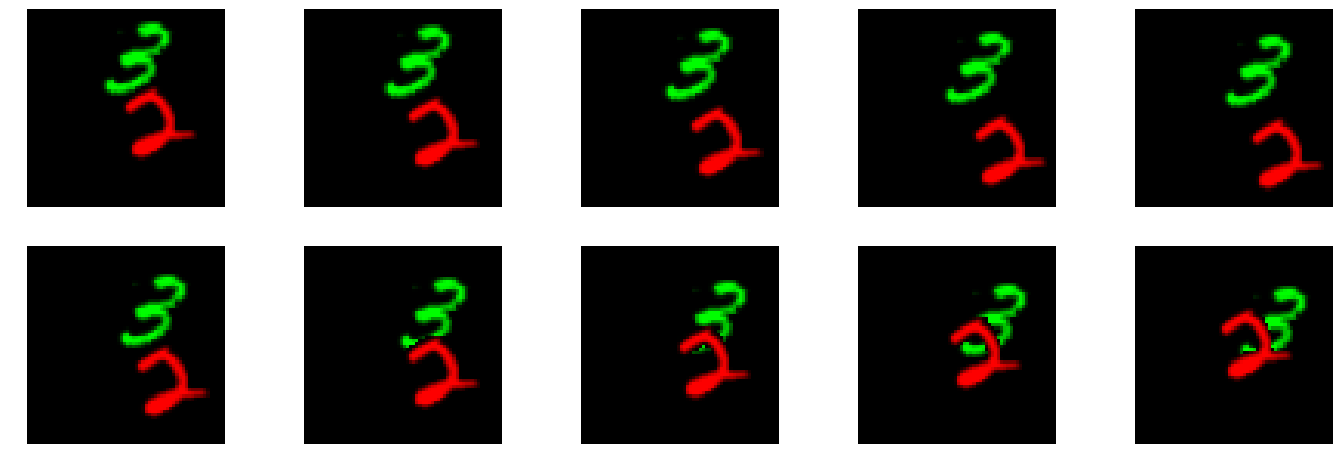

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


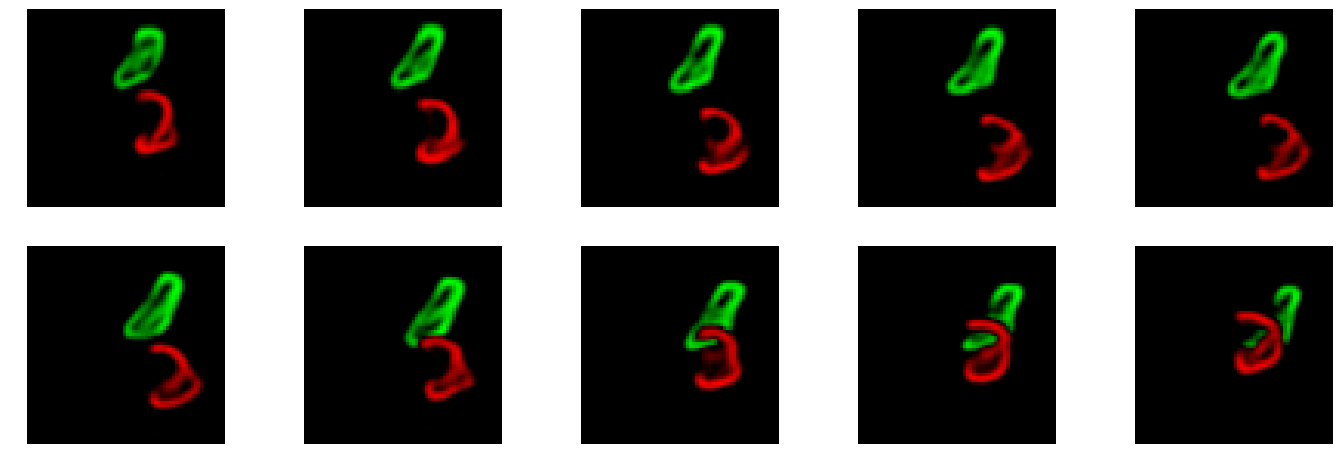

In [9]:
epochs = 10
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [10]:
opt = optimizers.Adam(lr = 5e-5, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 11/30
100/100 [==============================] - 425s 4s/step - loss: 1.5477e-04 - mean_squared_error: 1.5005e-04 - val_loss: 1.9478e-04 - val_mean_squared_error: 1.9007e-04

Epoch 00011: saving model to ./models/model0616_256.hdf5
Epoch 12/30
100/100 [==============================] - 420s 4s/step - loss: 1.5422e-04 - mean_squared_error: 1.4952e-04 - val_loss: 1.9407e-04 - val_mean_squared_error: 1.8936e-04

Epoch 00012: saving model to ./models/model0616_256.hdf5
Epoch 13/30
100/100 [==============================] - 420s 4s/step - loss: 1.5386e-04 - mean_squared_error: 1.4917e-04 - val_loss: 1.9426e-04 - val_mean_squared_error: 1.8957e-04

Epoch 00013: saving model to ./models/model0616_256.hdf5
Epoch 14/30
100/100 [==============================] - 420s 4s/step - loss: 1.5389e-04 - mean_squared_error: 1.4921e-04 - val_loss: 1.9410e-04 - val_mean_squared_error: 1.8942e-04

Epoch 00014: saving model to ./models/model0616_256.hdf5
Epoch 15/30
100/100 [===========================

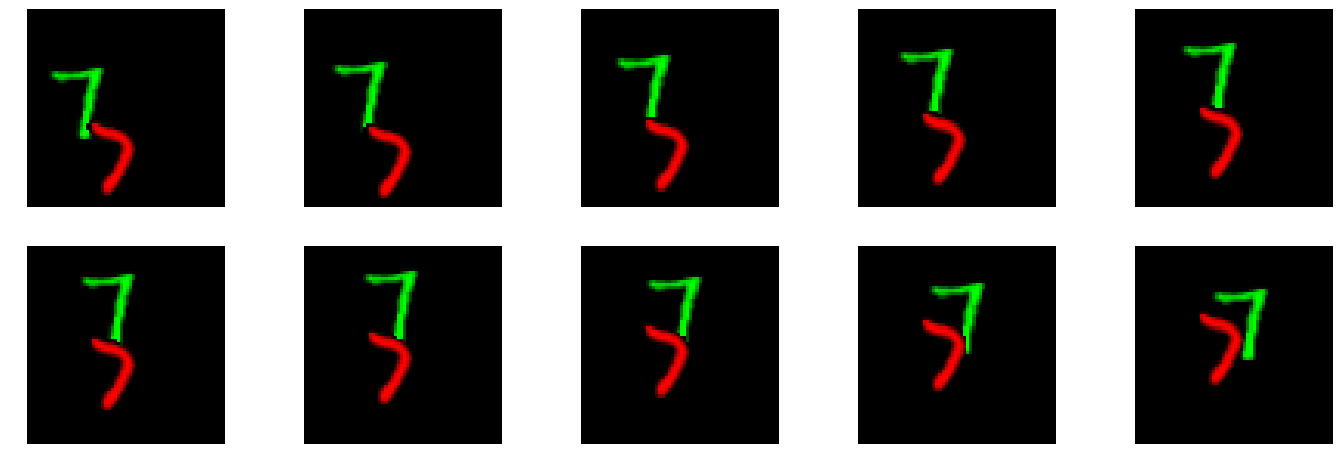

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


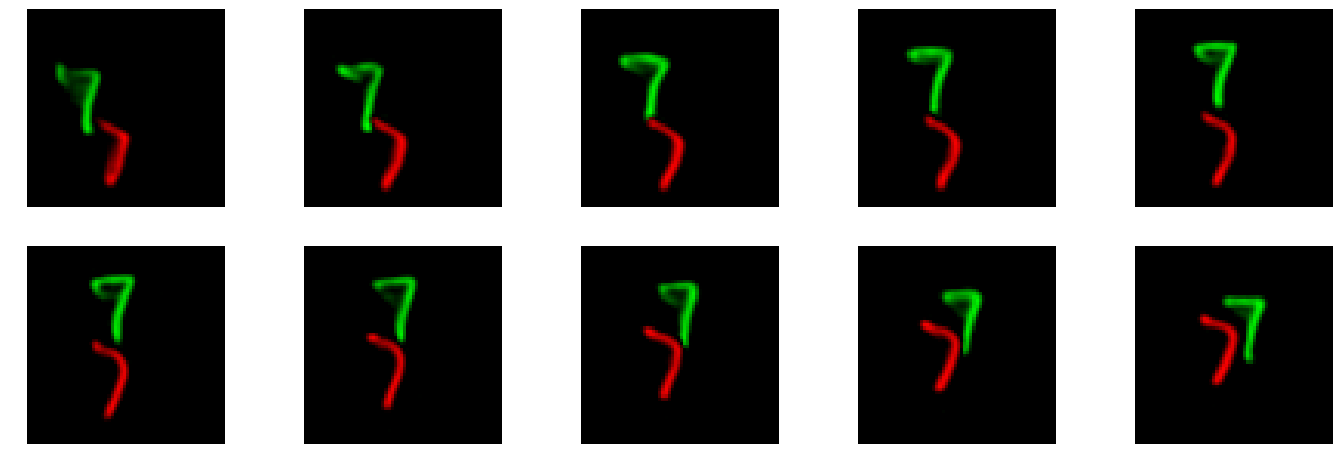

In [11]:
epochs = 30
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [12]:
opt = optimizers.Adam(lr = 2e-5, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 31/50
100/100 [==============================] - 426s 4s/step - loss: 1.5303e-04 - mean_squared_error: 1.4849e-04 - val_loss: 1.9426e-04 - val_mean_squared_error: 1.8972e-04

Epoch 00031: saving model to ./models/model0616_256.hdf5
Epoch 32/50
100/100 [==============================] - 420s 4s/step - loss: 1.5345e-04 - mean_squared_error: 1.4891e-04 - val_loss: 1.9425e-04 - val_mean_squared_error: 1.8972e-04

Epoch 00032: saving model to ./models/model0616_256.hdf5
Epoch 33/50
100/100 [==============================] - 420s 4s/step - loss: 1.5264e-04 - mean_squared_error: 1.4810e-04 - val_loss: 1.9410e-04 - val_mean_squared_error: 1.8957e-04

Epoch 00033: saving model to ./models/model0616_256.hdf5
Epoch 34/50
100/100 [==============================] - 421s 4s/step - loss: 1.5316e-04 - mean_squared_error: 1.4863e-04 - val_loss: 1.9369e-04 - val_mean_squared_error: 1.8916e-04

Epoch 00034: saving model to ./models/model0616_256.hdf5
Epoch 35/50
100/100 [===========================

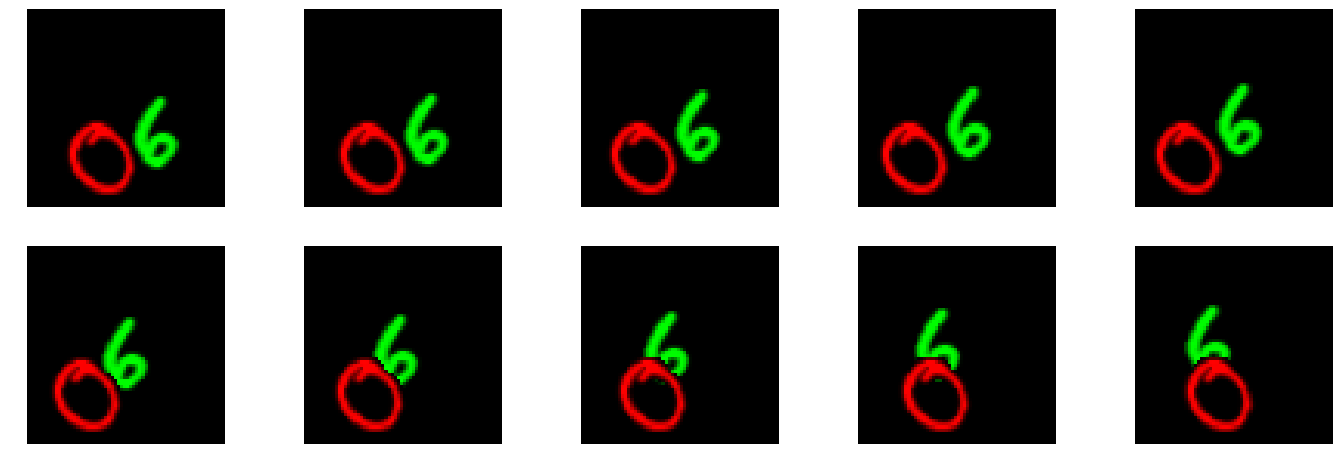

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

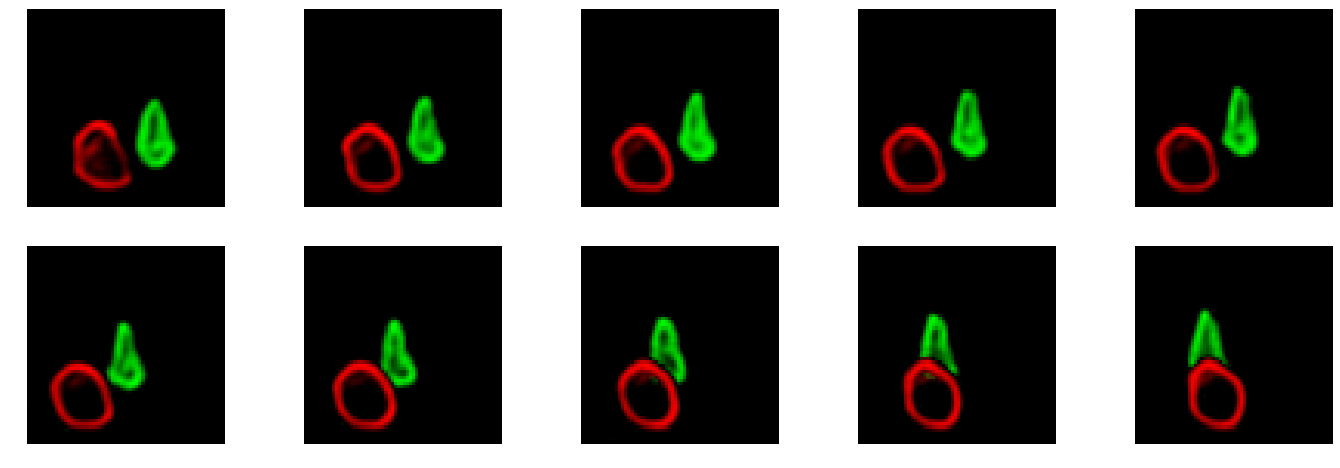

In [13]:
epochs = 50
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [16]:
opt = optimizers.Adam(lr = 1e-5, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Epoch 51/60
100/100 [==============================] - 430s 4s/step - loss: 1.5249e-04 - mean_squared_error: 1.4803e-04 - val_loss: 1.9351e-04 - val_mean_squared_error: 1.8904e-04

Epoch 00051: saving model to ./models/model0616_256.hdf5
Epoch 52/60
100/100 [==============================] - 425s 4s/step - loss: 1.5263e-04 - mean_squared_error: 1.4817e-04 - val_loss: 1.9352e-04 - val_mean_squared_error: 1.8906e-04

Epoch 00052: saving model to ./models/model0616_256.hdf5
Epoch 53/60
100/100 [==============================] - 424s 4s/step - loss: 1.5253e-04 - mean_squared_error: 1.4807e-04 - val_loss: 1.9385e-04 - val_mean_squared_error: 1.8939e-04

Epoch 00053: saving model to ./models/model0616_256.hdf5
Epoch 54/60
100/100 [==============================] - 425s 4s/step - loss: 1.5240e-04 - mean_squared_error: 1.4795e-04 - val_loss: 1.9390e-04 - val_mean_squared_error: 1.8944e-04

Epoch 00054: saving model to ./models/model0616_256.hdf5
Epoch 55/60
100/100 [===========================

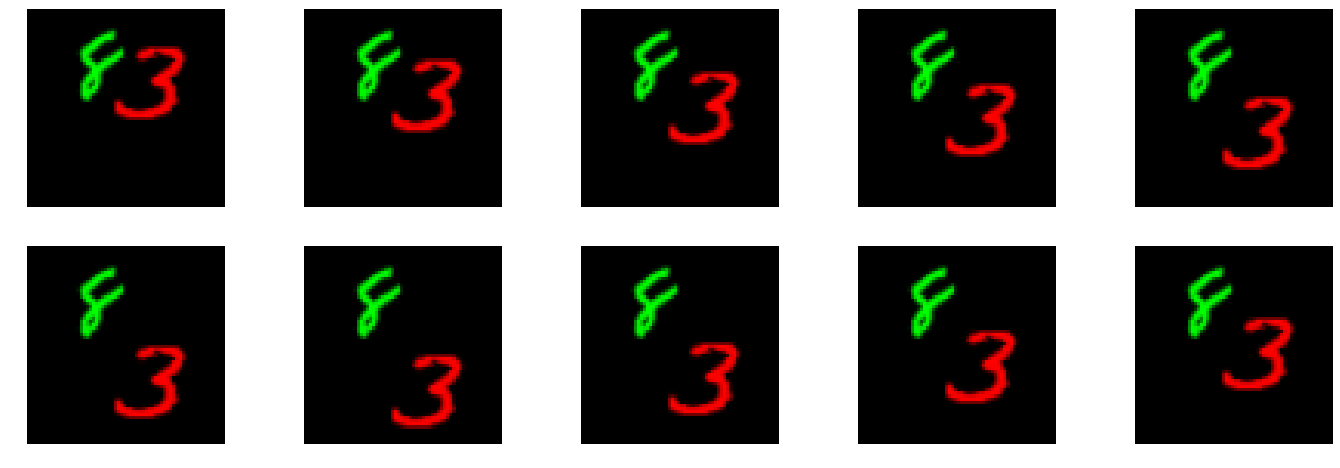

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


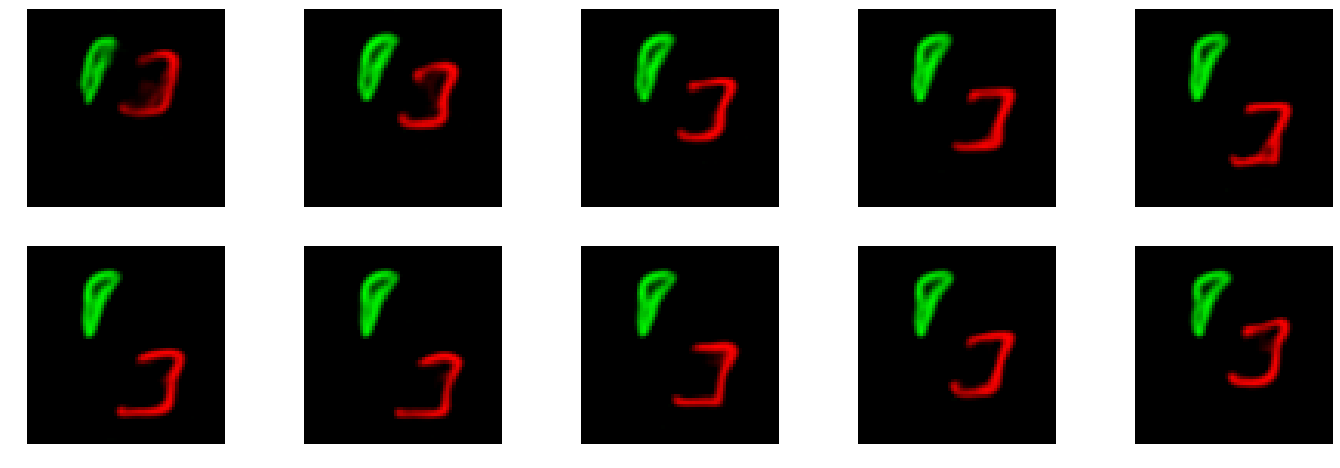

In [17]:
epochs = 60
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

In [18]:
opt = optimizers.Adam(lr = 5e-6, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

In [ ]:
epochs = 80
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

Epoch 61/80
100/100 [==============================] - 424s 4s/step - loss: 1.5210e-04 - mean_squared_error: 1.4765e-04 - val_loss: 1.9338e-04 - val_mean_squared_error: 1.8894e-04

Epoch 00061: saving model to ./models/model0616_256.hdf5
Epoch 62/80
100/100 [==============================] - 419s 4s/step - loss: 1.5192e-04 - mean_squared_error: 1.4748e-04 - val_loss: 1.9342e-04 - val_mean_squared_error: 1.8898e-04

Epoch 00062: saving model to ./models/model0616_256.hdf5
Epoch 63/80
 22/100 [=====>........................] - ETA: 5:29 - loss: 1.5203e-04 - mean_squared_error: 1.4759e-04

In [6]:
model = load_model('./models/model0616_256.hdf5')
opt = optimizers.Adam(lr = 2e-6, decay = 0.0, amsgrad = False)
model.compile(optimizer = opt, loss = 'mse', metrics = ['mse'])

Instructions for updating:
Use tf.cast instead.


Epoch 1/10
100/100 [==============================] - 923s 9s/step - loss: 1.5185e-04 - mean_squared_error: 1.4741e-04 - val_loss: 1.9345e-04 - val_mean_squared_error: 1.8901e-04

Epoch 00001: saving model to ./models/model0616_256.hdf5
Epoch 2/10
100/100 [==============================] - 495s 5s/step - loss: 1.5153e-04 - mean_squared_error: 1.4709e-04 - val_loss: 1.9342e-04 - val_mean_squared_error: 1.8898e-04

Epoch 00002: saving model to ./models/model0616_256.hdf5
Epoch 3/10
100/100 [==============================] - 430s 4s/step - loss: 1.5150e-04 - mean_squared_error: 1.4706e-04 - val_loss: 1.9336e-04 - val_mean_squared_error: 1.8892e-04

Epoch 00003: saving model to ./models/model0616_256.hdf5
Epoch 4/10
100/100 [==============================] - 422s 4s/step - loss: 1.5199e-04 - mean_squared_error: 1.4755e-04 - val_loss: 1.9333e-04 - val_mean_squared_error: 1.8889e-04

Epoch 00004: saving model to ./models/model0616_256.hdf5
Epoch 5/10
100/100 [==============================] 

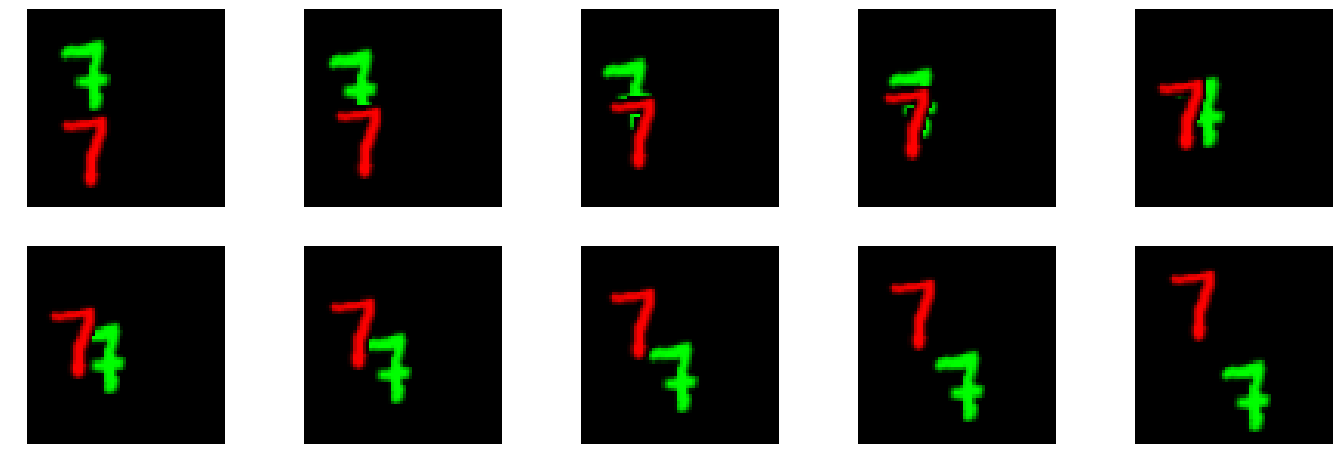

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


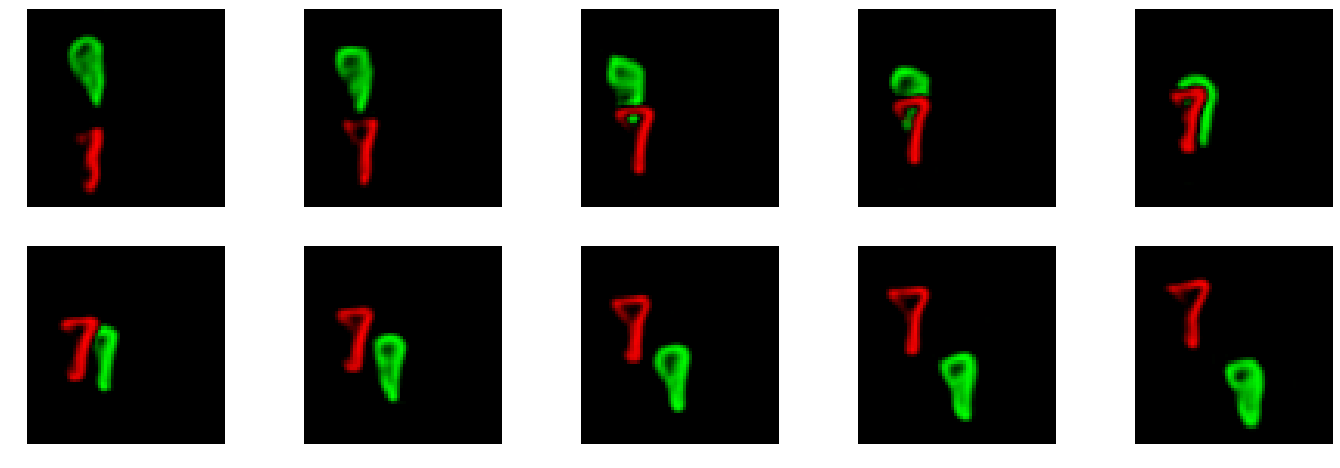

In [7]:
initial_epoch = 0

epochs = 10
batch_size = 200

CP = ModelCheckpoint(filepath = './models/model0616_256.hdf5', monitor = 'val_loss', verbose = 1, save_best_only = False, mode = 'auto')
ES = EarlyStopping(monitor = 'val_loss', patience = 30, verbose = 1, mode = 'auto', restore_best_weights = True)
LS = LearningRateScheduler(schedule, verbose = 1)

history = model.fit_generator(batch_data_generator_for_LSTM(batch_size), steps_per_epoch = n_train // batch_size, epochs = epochs,
                              verbose = 1, callbacks = [CP], validation_data = (val_input_batch, val_output_batch),
                              shuffle = True, initial_epoch = initial_epoch)

initial_epoch = epochs
_, _ = show_outputs()

# Feature distribution

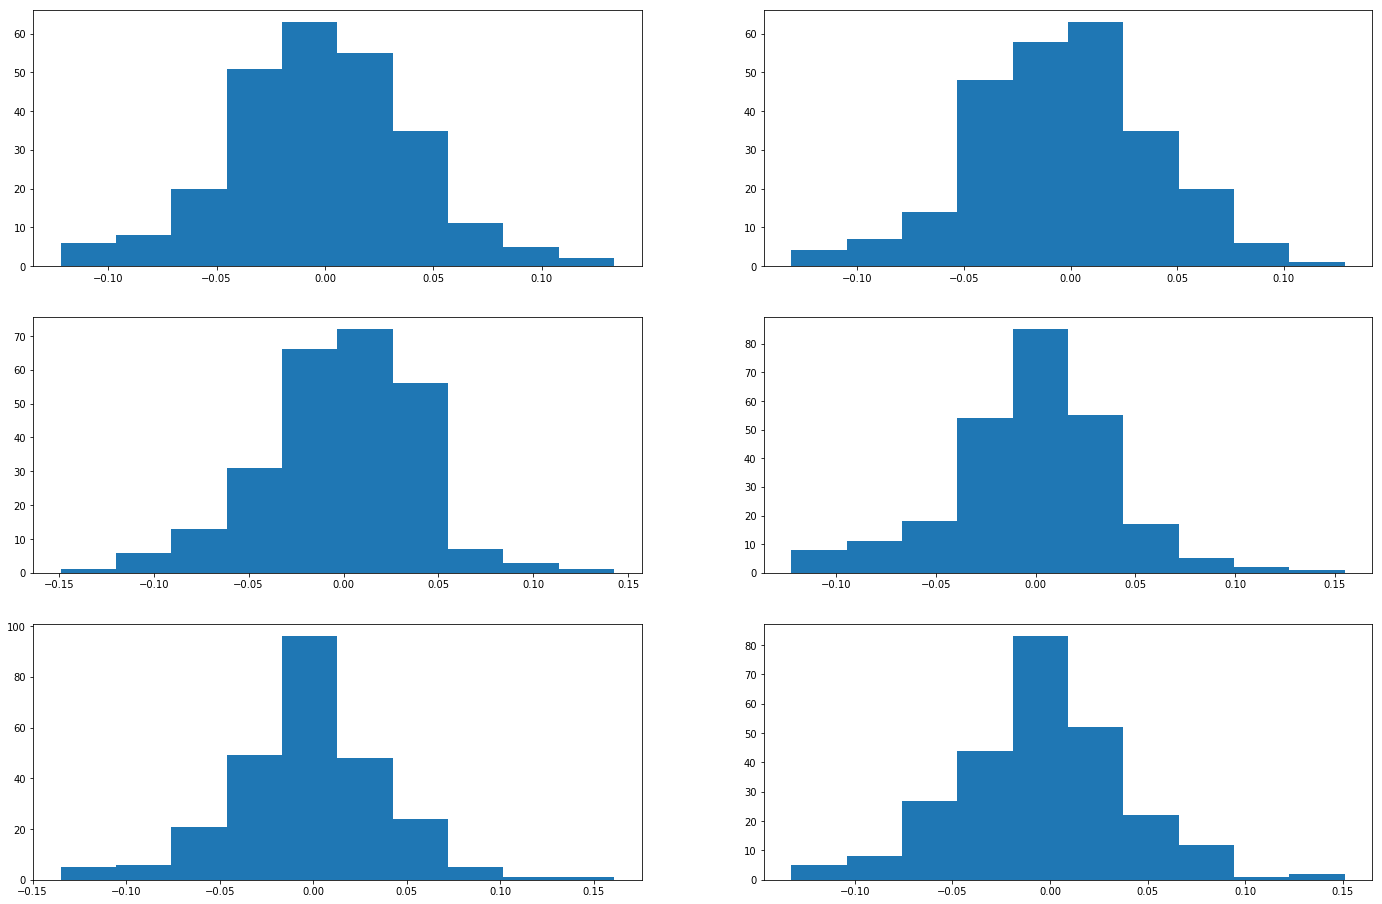

In [19]:
batch1, batch2 = get_train_batch(1)
X_batch = np.concatenate([batch1, batch2])
X_batch = np.reshape(X_batch, (-1, 64, 64, 3))
features = encoder.predict_on_batch(X_batch)
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()

In [ ]:
f_0 = features[0]
f_1 = features[1]
f_2 = features[2]
f_3 = features[3]
f_10 = features[10]

In [ ]:
plt.hist(f_0, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_10, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_2, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
plt.hist(f_3, bins='auto')  # arguments are passed to np.histogram
plt.show()

In [ ]:
inputs, answers = get_train_batch(1)
inputs = np.reshape(inputs, (-1, 64, 64, 3))
answers = np.reshape(answers, (-1, 64, 64, 3))
inputs = inputs[:, :, :, :2]
encoded_inputs = encoder.predict_on_batch(inputs)
encoded_inputs = encoded_inputs[None, :, :]
dummy_inputs = np.zeros_like(encoded_inputs, dtype = np.float32)
encoded = np.concatenate([encoded_inputs, dummy_inputs], axis = 1)
features = model.predict_on_batch(encoded)
features = np.reshape(features, (-1, dim))
fig = plt.figure(figsize = (24, 16))
for i in range(0, 6):
    fig.add_subplot(3, 2, i+1)
    plt.hist(features[i])
plt.show()